In [ ]:
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Dict, Callable

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Array = np.ndarray

# ===========================
# Utils
# ===========================
def standardize_global(X: Array) -> Tuple[Array, Array, Array]:
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True)
    sigma = sigma + 1e-8
    Xn = (X - mu) / sigma
    return Xn, mu.squeeze(0), sigma.squeeze(0)

def make_lr_schedule(T: int, base_lr: float = 1e-3, warmup_ratio: float = 0.2, min_lr_ratio: float = 1.0
) -> Callable[[int], float]:
    """t=1..T: linear warmup -> cosine。min_lr_ratio=1.0 で“実質定数LR”"""
    W = max(1, int(T * warmup_ratio))
    def lr_t(t: int) -> float:
        if t <= W:
            return base_lr * (t / W)
        s = (t - W) / max(1, T - W)
        return base_lr * (min_lr_ratio + 0.5 * (1 - min_lr_ratio) * (1 + math.cos(math.pi * s)))
    return lr_t

@torch.no_grad()
def _toggle_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)

# ===========================
# 入力勾配集計
# ===========================
def steinized_input_direction(model, Xn, batch_size=2048):
    model.eval(); _toggle_requires_grad(model, False)
    d = Xn.shape[1]
    acc = torch.zeros(d, device=Xn.device)
    count = 0; start = 0
    while start < Xn.shape[0]:
        end = min(start+batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += (Xb * grads).sum(dim=0)
        count += (end-start); start = end
    _toggle_requires_grad(model, True)
    return (acc / count).detach().cpu().numpy()

def corrgrad_input_direction(model: nn.Module,
                             Xn: torch.Tensor,
                             y: torch.Tensor,
                             batch_size: int = 2048) -> np.ndarray:
    """
    xi_std[j] = sum_i d/dx_{ij} ( (o_i - mean(o)) * (y_i - mean(y)) )
    クロスフィット側 y を使うので model とデータは独立性を保つ。
    """
    model.eval(); _toggle_requires_grad(model, False)
    nfeat = Xn.shape[1]
    acc = torch.zeros(nfeat, device=Xn.device)
    start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        yb = y[start:end].detach()
        out = model(Xb).view(-1)
        s = ((out - out.mean()) * (yb - yb.mean())).sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += grads.sum(dim=0)
        start = end
    _toggle_requires_grad(model, True)
    return acc.detach().cpu().numpy()


def sum_input_gradients_std(model: nn.Module, Xn: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    # RNN系は backward が eval だと動かないので train、それ以外は eval
    if any(isinstance(m, (nn.RNNBase, nn.LSTM, nn.GRU)) for m in model.modules()):
        model.train()
    else:
        model.eval()
    _toggle_requires_grad(model, False)
    nfeat = Xn.shape[1]
    xi_std = torch.zeros(nfeat, device=Xn.device)
    start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        xi_std += grads.sum(dim=0)
        start = end
    _toggle_requires_grad(model, True)
    return xi_std.detach().cpu().numpy()

# ===========================
# 集約/しきい値/評価
# ===========================
def psi_aggregate(a: Array, b: Array, method: str = "mean", eps: float = 1e-12) -> Array:
    if method == "min": return np.minimum(a, b)
    if method == "geomean": return np.sqrt(np.maximum(a*b, 0.0) + eps)
    if method == "mean": return 0.5 * (a + b)
    if method == "harmmean": return (2.0 * a * b) / (a + b + eps)
    raise ValueError("Unknown psi method")

def _strict_threshold_candidates(M: Array) -> Array:
    vals = M[np.isfinite(M)]
    abs_vals = np.unique(np.abs(vals)); abs_vals = abs_vals[abs_vals > 0.0]
    if abs_vals.size == 0: return np.array([], dtype=float)
    abs_vals.sort(); a = np.concatenate([[0.0], abs_vals])
    return 0.5 * (a[:-1] + a[1:])

def strict_mirror_fdp_threshold(M: Array, alpha: float) -> Tuple[float, int, int, float]:
    assert 0.0 < alpha < 1.0
    cand = _strict_threshold_candidates(M)
    if cand.size == 0: return np.inf, 0, 0, np.inf
    for u in cand:
        Rp = int((M > u).sum()); Rm = int((M < -u).sum()) + 1; den = max(Rp, 1) ## added + 1
        fdp = Rm  / den
        if fdp <= alpha: return float(u), Rp, Rm, float(fdp)
    return np.inf, 0, 0, np.inf

def true_metrics(selected: Array, true_idx: Optional[Array], n: int) -> Tuple[Optional[float], Optional[float]]:
    if true_idx is None or len(true_idx) == 0: return None, None
    S = set(int(i) for i in selected.tolist()); T = set(int(i) for i in np.array(true_idx).tolist())
    R = len(S); TP = len(S & T); FP = R - TP; FN = len(T - S)
    FDR_true = FP / max(R, 1); TypeII = FN / max(len(T), 1)
    return float(FDR_true), float(TypeII)

# ===========================
# PathResult
# ===========================
@dataclass
class PathResult:
    steps: Array; tau: Array; R_plus: Array; R_minus: Array; FDPhat: Array
    FDR_true: Optional[Array]; TypeII: Optional[Array]
    last_xi1: Array; last_xi2: Array; last_M: Array; last_selected: Array; last_tau: float
    loss_steps: Array = field(default_factory=lambda: np.array([], dtype=int))
    loss_values: Array = field(default_factory=lambda: np.array([], dtype=float))
    xi1_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    xi2_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    M_hist:   Array = field(default_factory=lambda: np.empty((0,0), dtype=float))

# ===========================
# MLP
# ===========================
class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, bias_init=0.0, init_mode="he", fixed_sigma=0.01, activation="relu"):
        super().__init__()
        dims = [input_dim] + hidden_dims + [1]
        self.layers = nn.ModuleList([nn.Linear(dims[i], dims[i+1], bias=True) for i in range(len(dims)-1)])
        self.hidden_dims = hidden_dims; self.bias_init = bias_init; self.init_mode = init_mode
        self.fixed_sigma = fixed_sigma; self.activation = activation.lower()
        self.reset_parameters()
    def _act(self, z):
        a = self.activation
        if a == "relu": return F.relu(z)
        if a == "leaky_relu": return F.leaky_relu(z, negative_slope=0.01)
        if a == "elu": return F.elu(z, alpha=1.0)
        if a in ("silu", "swish"): return F.silu(z)
        if a == "gelu": return F.gelu(z)
        if a == "tanh": return torch.tanh(z)
        if a == "softplus": return F.softplus(z, beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def reset_parameters(self):
        with torch.no_grad():
            for lin in self.layers:
                din = lin.in_features
                if self.init_mode == "he": sigma = np.sqrt(2.0 / din)
                elif self.init_mode == "xavier": sigma = np.sqrt(1.0 / din)
                elif self.init_mode is None: sigma = self.fixed_sigma
                else: raise ValueError("Unsupported init_mode")
                lin.weight.normal_(0.0, float(sigma)); lin.bias.fill_(float(self.bias_init))
    def forward(self, x):
        h = x
        for i in range(len(self.hidden_dims)):
            h = self._act(self.layers[i](h))
        return self.layers[-1](h)

# ===========================
# Lifted CNN/RNN/Transformer
# ===========================
def _init_lift_weight_gaussian_(lin: nn.Linear, fan_in: int, mode: str = "he", fixed_sigma: float = 0.01):
    with torch.no_grad():
        if mode == "he": sigma = (2.0 / float(fan_in)) ** 0.5
        elif mode == "xavier": sigma = (1.0 / float(fan_in)) ** 0.5
        elif mode == "fixed": sigma = float(fixed_sigma)
        else: raise ValueError("lift_init_mode must be 'he'|'xavier'|'fixed'")
        lin.weight.normal_(0.0, sigma)
        if lin.bias is not None: lin.bias.zero_()

class TorchCNN1D_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int,
                 conv_channels: list = [64, 64], kernel_sizes: list = [11, 7], strides: list = [1, 1],
                 fc_dims: list = [128], activation: str = "relu", init_mode: str = "he",
                 bias_init: float = 0.0, dropout: float = 0.0, use_bn: bool = False,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert len(conv_channels) == len(kernel_sizes) == len(strides)
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.use_bn = use_bn; self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        layers = []; in_ch = 1
        for c, k, s in zip(conv_channels, kernel_sizes, strides):
            pad = k // 2
            layers.append(nn.Conv1d(in_ch, c, kernel_size=k, stride=s, padding=pad, bias=True))
            if use_bn: layers.append(nn.BatchNorm1d(c))
            layers.append(self._act_layer())
            if dropout > 0: layers.append(nn.Dropout(dropout))
            in_ch = c
        self.conv = nn.Sequential(*layers); self.gap = nn.AdaptiveAvgPool1d(1)
        dims = [in_ch] + list(fc_dims) + [1]; fcs = []
        for i in range(len(dims) - 2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True))
            fcs.append(self._act_layer())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma); self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu", "swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            for m in self.modules():
                if m is self.W1: continue
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    if self.init_mode == "he": nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    elif self.init_mode == "xavier": nn.init.xavier_normal_(m.weight)
                    else: nn.init.normal_(m.weight, 0.0, 0.01)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
                elif isinstance(m, (nn.BatchNorm1d,)): nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); y = z.unsqueeze(1); y = self.conv(y); y = self.gap(y).squeeze(-1)
        return self.head(y)

class TorchRNN_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int, rnn_type: str = "lstm",
                 hidden_size: int = 128, num_layers: int = 1, bidirectional: bool = False,
                 input_proj_dim: int = 1, fc_dims: list = [128], activation: str = "relu",
                 init_mode: str = "xavier", bias_init: float = 0.0, dropout: float = 0.0,
                 lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01):
        super().__init__()
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.rnn_type = rnn_type.lower(); self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        self.input_proj = nn.Identity(); rnn_input_size = 1
        if input_proj_dim > 1: self.input_proj = nn.Linear(1, input_proj_dim, bias=True); rnn_input_size = input_proj_dim
        common = dict(input_size=rnn_input_size, hidden_size=hidden_size, num_layers=num_layers,
                      batch_first=True, dropout=(dropout if num_layers > 1 else 0.0),
                      bidirectional=bidirectional)
        if self.rnn_type == "lstm": self.rnn = nn.LSTM(**common)
        elif self.rnn_type == "gru": self.rnn = nn.GRU(**common)
        else: raise ValueError("rnn_type must be 'lstm' or 'gru'")
        out_dim = hidden_size * (2 if bidirectional else 1)
        dims = [out_dim] + list(fc_dims) + [1]; fcs = []
        for i in range(len(dims) - 2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma); self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu", "swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            # input_proj / head
            if isinstance(self.input_proj, nn.Linear):
                nn.init.xavier_uniform_(self.input_proj.weight)
                if self.input_proj.bias is not None: self.input_proj.bias.fill_(float(self.bias_init))
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))

            # RNN 本体（LSTM/GRU で分岐）
            for name, p in self.rnn.named_parameters():
                if "weight_ih" in name:
                    nn.init.xavier_uniform_(p)               # 入力→隠れ
                elif "weight_hh" in name:
                    for i in range(p.size(0) // self.rnn.hidden_size):
                        # ブロック毎に直交初始化
                        hh = p[i*self.rnn.hidden_size:(i+1)*self.rnn.hidden_size]
                        nn.init.orthogonal_(hh)
                elif "bias" in name:
                    p.fill_(float(self.bias_init))
                    if self.rnn_type == "lstm":
                        # [i, f, g, o] の順で f に +1
                        hidden = self.rnn.hidden_size
                        p[hidden:2*hidden] += 1.0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); s = z.unsqueeze(-1); s = self.input_proj(s)
        if self.rnn_type == "lstm":
            out, (h_n, c_n) = self.rnn(s)
            last_fwd = h_n[-1]
            if self.rnn.bidirectional: last = torch.cat([h_n[-2], h_n[-1]], dim=-1)
            else: last = last_fwd
        else:
            out, h_n = self.rnn(s); last_fwd = h_n[-1]
            if self.rnn.bidirectional: last = torch.cat([h_n[-2], h_n[-1]], dim=-1)
            else: last = last_fwd
        return self.head(last)

# ---- Positional Encoding ----
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div); pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1); return x + self.pe[:L].unsqueeze(0)

# ---- 安定化済み Transformer（Encoderはデフォ初期化を保持）----
class TorchTransformer1D_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int, d_model: int = 128, nhead: int = 8, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1, activation: str = "relu",
                 init_mode: str = "he", bias_init: float = 0.0, pool: str = "mean",
                 use_sinusoidal_pos: bool = True, fc_dims: list = [128],
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert d_model % nhead == 0
        self.pool = pool.lower()
        self.head_activation = activation.lower()
        self.input_dim = input_dim
        self.lift_dim = lift_dim
        # --- Linear lift ---
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        # --- in-proj, input LayerNorm, pos ---
        self.in_proj = nn.Linear(1, d_model, bias=True)
        self.input_ln = nn.LayerNorm(d_model)  # ★ 追加：埋め込みの振れ止め
        self.pos = SinusoidalPositionalEncoding(d_model) if use_sinusoidal_pos else nn.Embedding(10000, d_model)
        # --- Encoder（初期化は触らない）---
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        if self.pool == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        # --- head ---
        dims = [d_model] + list(fc_dims) + [1]; fcs = []
        for i in range(len(dims) - 2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True))
            fcs.append(self._act_layer())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        # --- init: W1, in_proj, head のみ適度に初期化（Encoderはそのまま）---
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        with torch.no_grad():
            nn.init.xavier_uniform_(self.in_proj.weight)
            if self.in_proj.bias is not None: self.in_proj.bias.zero_()
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.zero_()
    def _act_layer(self):
        a = self.head_activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu", "swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x)              # (B,q)
        s = z.unsqueeze(-1)         # (B,q,1)
        s = self.in_proj(s)         # ★ sqrt(d_model) は掛けない
        s = self.input_ln(s)
        if isinstance(self.pos, SinusoidalPositionalEncoding):
            s = self.pos(s)
        else:
            B, L, _ = s.shape; pos_ids = torch.arange(L, device=s.device).unsqueeze(0).expand(B, L)
            s = s + self.pos(pos_ids)
        if self.pool == "cls":
            B = s.shape[0]; cls = self.cls.expand(B, -1, -1); s = torch.cat([cls, s], dim=1)
        h = self.encoder(s)
        pooled = h[:, 0, :] if self.pool == "cls" else h.mean(dim=1)
        return self.head(pooled).view(-1, 1)

# ===========================
# 学習 1 ステップ（clip_max_norm 付き・NaN ガード）
# ===========================
def one_sgd_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor,
                 optimizer: torch.optim.Optimizer, loss_type: str,
                 batch_size: int, g: torch.Generator,
                 clip_max_norm: float = 1.0) -> float:
    m = X.shape[0]
    idx = torch.randint(low=0, high=m, size=(min(batch_size, m),), generator=g, device=X.device)
    Xb = X.index_select(0, idx); yb = y.index_select(0, idx).view(-1, 1)
    model.train(); optimizer.zero_grad(set_to_none=True)
    logits = model(Xb)  # (B,1)
    if loss_type == "mse": loss = 0.5 * torch.mean((logits - yb)**2)
    elif loss_type == "logistic": loss = F.binary_cross_entropy_with_logits(logits, yb)
    else: raise ValueError("loss_type must be 'mse' or 'logistic'")
    loss.backward()
    if clip_max_norm is not None and clip_max_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
    optimizer.step()
    val = float(loss.detach().cpu().item())
    if not np.isfinite(val):
        for g in optimizer.param_groups: g["lr"] *= 0.25
    return val

# ===========================
# 汎用 Path（v2 互換：y標準化・LRスケジュール・clip 対応）
# ===========================
def torch_nn_feature_selection_path_generic(
    X: Array, y: Array, alpha: float, T: int, build_model: Callable[[int], nn.Module],
    true_idx: Optional[Array] = None, batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min", seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048, xi_mode: str = "sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
    optimizer: str = "sgd", momentum: float = 0.0, clip_max_norm: float = 1.0,
) -> PathResult:
    assert 0.0 < alpha < 1.0 and T >= 1
    m, n = X.shape
    Xn, mu, sigma = standardize_global(X)
    # y 標準化（スケール安定）
    y_mu = y.mean(); y_std = y.std() + 1e-12; y_tilde = (y - y_mu) / y_std

    rng_np = np.random.default_rng(seed_split)
    perm = rng_np.permutation(m); m1 = m // 2
    idx1 = perm[:m1]; idx2 = perm[m1:]
    X1n = torch.tensor(Xn[idx1], dtype=torch.float32, device=device)
    X2n = torch.tensor(Xn[idx2], dtype=torch.float32, device=device)
    y1 = torch.tensor(y_tilde[idx1], dtype=torch.float32, device=device)
    y2 = torch.tensor(y_tilde[idx2], dtype=torch.float32, device=device)

    torch.manual_seed(seed_model1); model1 = build_model(n).to(device)
    torch.manual_seed(seed_model2); model2 = build_model(n).to(device)

    opt1: torch.optim.Optimizer
    opt2: torch.optim.Optimizer
    if optimizer.lower() == "adamw":
        opt1 = torch.optim.AdamW(model1.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.95), eps=1e-8)
        opt2 = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.95), eps=1e-8)
    elif optimizer.lower() == "sgd":
        opt1 = torch.optim.SGD(model1.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
        opt2 = torch.optim.SGD(model2.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
    else:
        raise ValueError("optimizer must be 'sgd' or 'adamw'")

    if lr_schedule is None:
        def lr_schedule(t: int, _lr=lr): return _lr
    g1 = torch.Generator(device=device).manual_seed(seed_model1 + 1)
    g2 = torch.Generator(device=device).manual_seed(seed_model2 + 1)

    steps, taus, Rps, Rms, FDPs = [], [], [], [], []
    FDRs, T2s = [], []
    loss_steps, loss_values = [], []; loss_accum, loss_count = 0.0, 0
    xi1_list, xi2_list, M_list = [], [], []
    last_xi1 = last_xi2 = last_M = None; last_selected = np.array([], dtype=int); last_tau = np.inf

    for t in range(1, T+1):
        lr_now = lr_schedule(t)
        for g in opt1.param_groups: g["lr"] = lr_now
        for g in opt2.param_groups: g["lr"] = lr_now

        l1 = one_sgd_step(model1, X1n, y1, opt1, loss, batch_size, g1, clip_max_norm=clip_max_norm)
        l2 = one_sgd_step(model2, X2n, y2, opt2, loss, batch_size, g2, clip_max_norm=clip_max_norm)
        loss_accum += 0.5 * (l1 + l2); loss_count += 1

        if (t % compute_every) == 0 or (t == T):
            loss_steps.append(t); loss_values.append(loss_accum / max(loss_count, 1))
            loss_accum, loss_count = 0.0, 0

            if xi_mode == "sumgrad":
                xi1_std = sum_input_gradients_std(model2, X1n, batch_size=xi_batch)
                xi2_std = sum_input_gradients_std(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "steinized":
                xi1_std = steinized_input_direction(model2, X1n, batch_size=xi_batch)
                xi2_std = steinized_input_direction(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "corrgrad":
                xi1_std = corrgrad_input_direction(model2, X1n, y1, batch_size=xi_batch)
                xi2_std = corrgrad_input_direction(model1, X2n, y2, batch_size=xi_batch)
            else:
                raise ValueError("xi_mode must be 'sumgrad' | 'steinized' | 'corrgrad'")

            xi1 = xi1_std / sigma; xi2 = xi2_std / sigma
            sgn = np.sign(xi1 * xi2); mag = psi_aggregate(np.abs(xi1), np.abs(xi2), method=psi_method)
            M = sgn * mag

            # ★ 履歴の append を忘れずに
            xi1_list.append(xi1.copy()); xi2_list.append(xi2.copy()); M_list.append(M.copy())

            tau, Rp, Rm, FDPhat = strict_mirror_fdp_threshold(M, alpha=alpha)
            selected = np.where(M > tau)[0] if np.isfinite(tau) else np.array([], dtype=int)
            FDR_true, TypeII = true_metrics(selected, true_idx, n)
            steps.append(t); taus.append(tau); Rps.append(Rp); Rms.append(Rm); FDPs.append(FDPhat)
            FDRs.append(FDR_true if FDR_true is not None else np.nan); T2s.append(TypeII if TypeII is not None else np.nan)
            last_xi1, last_xi2, last_M = xi1, xi2, M; last_selected = selected; last_tau = tau

    xi1_hist = np.stack(xi1_list, axis=0) if xi1_list else np.empty((0,0))
    xi2_hist = np.stack(xi2_list, axis=0) if xi2_list else np.empty((0,0))
    M_hist   = np.stack(M_list,   axis=0) if M_list   else np.empty((0,0))
    return PathResult(np.array(steps,int), np.array(taus,float), np.array(Rps,int), np.array(Rms,int),
                      np.array(FDPs,float),
                      np.array(FDRs,float) if (true_idx is not None and len(true_idx)>0) else None,
                      np.array(T2s,float) if (true_idx is not None and len(true_idx)>0) else None,
                      last_xi1, last_xi2, last_M, last_selected, float(last_tau),
                      np.array(loss_steps,int), np.array(loss_values,float), xi1_hist, xi2_hist, M_hist)

# ===========================
# v2 互換 Path（MLP/CNN/RNN/Transformer ラッパ）
# ===========================
def torch_nn_feature_selection_path(
    X: Array, y: Array, alpha: float, T: int,
    true_idx: Optional[Array] = None,
    hidden_dims: List[int] = [64, 64],
    batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min",
    seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048,
    activation: str = "relu", init_mode: str = "he",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    def _build(n_in: int) -> nn.Module:
        return TorchMLP(n_in, hidden_dims, bias_init=0.0, init_mode=init_mode, activation=activation)
    # MLP は v1 の感触に合わせて SGD, lrは呼び出し引数をそのまま
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode="sumgrad",
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_cnn1d_feature_selection_path(
    X, y, alpha, T,
    true_idx=None,
    # --- lift ---
    lift_dim: int | None = None,
    lift_init_mode: str = "he",
    lift_fixed_sigma: float = 0.01,
    # --- CNN hyper ---
    conv_channels=[64, 64],
    kernel_sizes=[11, 7],
    strides=[1, 1],
    fc_dims=[128],
    activation="relu",
    init_mode="he",
    bias_init=0.0,
    dropout=0.0,
    use_bn=False,
    # --- training ---
    batch_size=128, lr=5e-3, weight_decay=0.0,          # ★ v1 相当へ復帰
    loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22,
    compute_every=10, xi_batch=2048, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchCNN1D_Lifted(
            input_dim=n_in, lift_dim=q,
            conv_channels=conv_channels, kernel_sizes=kernel_sizes, strides=strides,
            fc_dims=fc_dims, activation=activation, init_mode=init_mode, bias_init=bias_init,
            dropout=dropout, use_bn=use_bn,
            lift_init_mode=lift_init_mode, lift_fixed_sigma=lift_fixed_sigma
        )
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_rnn_feature_selection_path(
    X, y, alpha, T,
    true_idx=None,
    # --- lift ---
    lift_dim: int | None = None,
    lift_init_mode: str = "xavier",
    lift_fixed_sigma: float = 0.01,
    # --- RNN hyper ---
    rnn_type="lstm", hidden_size=128, num_layers=2, bidirectional=True,
    input_proj_dim=4, fc_dims=[64],
    activation="relu", init_mode="xavier", bias_init=0.0, dropout=0.1,
    # --- training ---
    batch_size=128, lr=5e-3, weight_decay=0.0,          # ★ v1 相当へ復帰
    loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22,
    compute_every=10, xi_batch=512, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchRNN_Lifted(
            input_dim=n_in, lift_dim=q,
            rnn_type=rnn_type, hidden_size=hidden_size, num_layers=num_layers,
            bidirectional=bidirectional, input_proj_dim=input_proj_dim,
            fc_dims=fc_dims, activation=activation, init_mode=init_mode, bias_init=bias_init, dropout=dropout,
            lift_init_mode=lift_init_mode, lift_fixed_sigma=lift_fixed_sigma
        )
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_transformer_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    # --- lift ---
    lift_dim: int | None = None,                   # 推奨: min(n, 512)
    # --- Transformer hyper ---
    d_model=128, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1,
    activation="gelu", init_mode="he", bias_init=0.0, pool="mean", use_sinusoidal_pos=True, fc_dims=[128],
    # --- training ---
    batch_size=256, lr=3e-4, weight_decay=0.01,    # ★ AdamW 推奨設定
    loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22,
    compute_every=10, xi_batch=512, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchTransformer1D_Lifted(
            input_dim=n_in, lift_dim=q,
            d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, activation=activation, init_mode=init_mode, bias_init=bias_init,
            pool=pool, use_sinusoidal_pos=use_sinusoidal_pos, fc_dims=fc_dims,
            lift_init_mode="he", lift_fixed_sigma=0.01
        )
    if lr_schedule is None:
        lr_schedule = make_lr_schedule(T, base_lr=lr, warmup_ratio=0.1, min_lr_ratio=1.0)  # 実質定数
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="adamw", momentum=0.0, clip_max_norm=1.0
    )

# ===========================
# DGP（そのまま）
# ===========================
def generate_sim_data(m: int, n: int, rng=None):
    q_star = 8
    if n < q_star: raise ValueError(f"n must be >= {q_star}, got n={n}")
    rng = np.random.default_rng(rng)
    X = rng.standard_normal((m, n))
    half = n // 2; b1 = np.zeros(n); b1[:half] = 2.0 / np.sqrt(n)
    B = np.zeros((n, q_star)); B[:, 0] = b1
    for k in range(2, q_star + 1): B[k-1, k-1] = 1.0
    def g(x): return (x - 2.0)**2
    def h(x): return np.maximum(x, 0.0)
    z1 = X @ B[:, 0]; y = g(z1)
    for k in range(2, q_star + 1):
        z_k = X @ B[:, k-1]; z_prev = X @ B[:, k-2]; y += h(z_k) * z_prev
    y += rng.standard_normal(m)
    idx_from_b1 = np.arange(half, dtype=int); idx_from_pairs = np.arange(q_star, dtype=int)
    true_idx = np.unique(np.concatenate([idx_from_b1, idx_from_pairs]))
    return X, y, true_idx, B

###======================
#  Demo Experiment
###======================

alpha = 0.1
T = 1000
m, n = 200, 50
X, y, true_idx, B = generate_sim_data(m=m, n=n, rng=0)

# ---- Transformer ----
path_tr = torch_transformer_feature_selection_path(
    X, y, alpha=0.1, T=T,
    true_idx=true_idx,
    lift_dim=min(n, 512),                      # ★ 推奨
    d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1,
    activation="gelu", init_mode="he", pool="mean", use_sinusoidal_pos=True, fc_dims=[128],
    batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="mean",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=512,
    xi_mode="corrgrad", lr_schedule=None
)

/home/geshu/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [1]:
# ============================================================
# FS Pipeline v3: 構造改良版（局所化トークン化＋ゲーティング・プーリング）
# - v2と同じ PathResult/出力仕様
# - Transformer: identity/patch/gaussian の持ち上げ選択、posなし既定、tanh-gated pooling
# - xi_mode: 'sumgrad' | 'steinized' | 'corrgrad'
# - LSTM: 正統初期化（weight_hh直交・forget bias +1）
# ============================================================
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Array = np.ndarray

# ===========================
# Utils
# ===========================
def standardize_global(X: Array) -> Tuple[Array, Array, Array]:
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True) + 1e-8
    return (X - mu) / sigma, mu.squeeze(0), sigma.squeeze(0)

def make_lr_schedule(T: int, base_lr: float = 1e-3, warmup_ratio: float = 0.1, min_lr_ratio: float = 1.0):
    W = max(1, int(T * warmup_ratio))
    def lr_t(t: int) -> float:
        if t <= W: return base_lr * (t / W)
        s = (t - W) / max(1, T - W)
        return base_lr * (min_lr_ratio + 0.5*(1 - min_lr_ratio)*(1 + math.cos(math.pi*s)))
    return lr_t

@torch.no_grad()
def _toggle_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)

# ===========================
# xi（入力勾配）の定義
# ===========================
def sum_input_gradients_std(model: nn.Module, Xn: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    # RNN は eval で autograd が落ちることがあるので train、それ以外は eval
    model.train() if any(isinstance(m, (nn.RNNBase, nn.LSTM, nn.GRU)) for m in model.modules()) else model.eval()
    _toggle_requires_grad(model, False)
    xi_std = torch.zeros(Xn.shape[1], device=Xn.device)
    start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        xi_std += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return xi_std.detach().cpu().numpy()

def steinized_input_direction(model, Xn, batch_size=2048):
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device); count = 0; start = 0
    while start < Xn.shape[0]:
        end = min(start+batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += (Xb * grads).sum(dim=0); count += (end-start); start = end
    _toggle_requires_grad(model, True)
    return (acc / count).detach().cpu().numpy()

def corrgrad_input_direction(model: nn.Module, Xn: torch.Tensor, y: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    """xi_std[j] = sum_i d/dx_{ij} ( (o_i-ȯ)*(y_i-ȳ) )"""
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device); start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        yb = y[start:end].detach()
        o = model(Xb).view(-1); s = ((o - o.mean()) * (yb - yb.mean())).sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return acc.detach().cpu().numpy()

# ===========================
# 集約/しきい値/評価
# ===========================
def psi_aggregate(a: Array, b: Array, method: str = "mean", eps: float = 1e-12) -> Array:
    if method == "min": return np.minimum(a, b)
    if method == "geomean": return np.sqrt(np.maximum(a*b, 0.0) + eps)
    if method == "mean": return 0.5*(a+b)
    if method == "harmmean": return (2.0*a*b) / (a+b+eps)
    raise ValueError("Unknown psi method")

def _strict_threshold_candidates(M: Array) -> Array:
    vals = M[np.isfinite(M)]
    abs_vals = np.unique(np.abs(vals)); abs_vals = abs_vals[abs_vals > 0.0]
    if abs_vals.size == 0: return np.array([], dtype=float)
    abs_vals.sort(); a = np.concatenate([[0.0], abs_vals])
    return 0.5*(a[:-1] + a[1:])

def strict_mirror_fdp_threshold(M: Array, alpha: float) -> Tuple[float, int, int, float]:
    assert 0.0 < alpha < 1.0
    cand = _strict_threshold_candidates(M)
    if cand.size == 0: return np.inf, 0, 0, np.inf
    for u in cand:
        Rp = int((M > u).sum()); Rm = int((M < -u).sum())
        fdp = Rm / max(Rp, 1)
        if fdp <= alpha: return float(u), Rp, Rm, float(fdp)
    return np.inf, 0, 0, np.inf

def true_metrics(selected: Array, true_idx: Optional[Array], n: int) -> Tuple[Optional[float], Optional[float]]:
    if true_idx is None or len(true_idx) == 0: return None, None
    S = set(int(i) for i in selected.tolist()); T = set(int(i) for i in np.array(true_idx).tolist())
    R = len(S); TP = len(S & T); FP = R - TP; FN = len(T - S)
    return float(FP / max(R,1)), float(FN / max(len(T),1))

# ===========================
# PathResult
# ===========================
@dataclass
class PathResult:
    steps: Array; tau: Array; R_plus: Array; R_minus: Array; FDPhat: Array
    FDR_true: Optional[Array]; TypeII: Optional[Array]
    last_xi1: Array; last_xi2: Array; last_M: Array; last_selected: Array; last_tau: float
    loss_steps: Array = field(default_factory=lambda: np.array([], dtype=int))
    loss_values: Array = field(default_factory=lambda: np.array([], dtype=float))
    xi1_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    xi2_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    M_hist:   Array = field(default_factory=lambda: np.empty((0,0), dtype=float))

# ===========================
# MLP
# ===========================
class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, bias_init=0.0, init_mode="he", fixed_sigma=0.01, activation="relu"):
        super().__init__()
        dims = [input_dim] + hidden_dims + [1]
        self.layers = nn.ModuleList([nn.Linear(dims[i], dims[i+1], bias=True) for i in range(len(dims)-1)])
        self.hidden_dims = hidden_dims; self.bias_init = bias_init; self.init_mode = init_mode
        self.fixed_sigma = fixed_sigma; self.activation = activation.lower()
        self.reset_parameters()
    def _act(self, z):
        a = self.activation
        if a == "relu": return F.relu(z)
        if a == "leaky_relu": return F.leaky_relu(z, 0.01)
        if a == "elu": return F.elu(z, 1.0)
        if a in ("silu", "swish"): return F.silu(z)
        if a == "gelu": return F.gelu(z)
        if a == "tanh": return torch.tanh(z)
        if a == "softplus": return F.softplus(z, beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def reset_parameters(self):
        with torch.no_grad():
            for lin in self.layers:
                din = lin.in_features
                if self.init_mode == "he": sigma = np.sqrt(2.0 / din)
                elif self.init_mode == "xavier": sigma = np.sqrt(1.0 / din)
                elif self.init_mode is None: sigma = self.fixed_sigma
                else: raise ValueError("Unsupported init_mode")
                lin.weight.normal_(0.0, float(sigma)); lin.bias.fill_(float(self.bias_init))
    def forward(self, x):
        h = x
        for i in range(len(self.hidden_dims)):
            h = self._act(self.layers[i](h))
        return self.layers[-1](h)

# ===========================
# Lift init helper
# ===========================
def _init_lift_weight_gaussian_(lin: nn.Linear, fan_in: int, mode: str = "he", fixed_sigma: float = 0.01):
    with torch.no_grad():
        if mode == "he": sigma = (2.0 / float(fan_in)) ** 0.5
        elif mode == "xavier": sigma = (1.0 / float(fan_in)) ** 0.5
        elif mode == "fixed": sigma = float(fixed_sigma)
        else: raise ValueError("lift_init_mode must be 'he'|'xavier'|'fixed'")
        lin.weight.normal_(0.0, sigma)
        if lin.bias is not None: lin.bias.zero_()

# ===========================
# CNN（そのまま）
# ===========================
class TorchCNN1D_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int,
                 conv_channels: list = [64, 64], kernel_sizes: list = [11, 7], strides: list = [1, 1],
                 fc_dims: list = [128], activation: str = "relu", init_mode: str = "he",
                 bias_init: float = 0.0, dropout: float = 0.0, use_bn: bool = False,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert len(conv_channels) == len(kernel_sizes) == len(strides)
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.use_bn = use_bn; self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        layers = []; in_ch = 1
        for c, k, s in zip(conv_channels, kernel_sizes, strides):
            pad = k // 2
            layers.append(nn.Conv1d(in_ch, c, kernel_size=k, stride=s, padding=pad, bias=True))
            if use_bn: layers.append(nn.BatchNorm1d(c))
            layers.append(self._act_layer())
            if dropout > 0: layers.append(nn.Dropout(dropout))
            in_ch = c
        self.conv = nn.Sequential(*layers); self.gap = nn.AdaptiveAvgPool1d(1)
        dims = [in_ch] + list(fc_dims) + [1]; fcs = []
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            for m in self.modules():
                if m is self.W1: continue
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    if self.init_mode == "he": nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    elif self.init_mode == "xavier": nn.init.xavier_normal_(m.weight)
                    else: nn.init.normal_(m.weight, 0.0, 0.01)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); y = z.unsqueeze(1); y = self.conv(y); y = self.gap(y).squeeze(-1)
        return self.head(y)

# ===========================
# RNN（初期化強化）
# ===========================
class TorchRNN_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int, rnn_type: str = "lstm",
                 hidden_size: int = 128, num_layers: int = 1, bidirectional: bool = False,
                 input_proj_dim: int = 1, fc_dims: list = [128], activation: str = "relu",
                 init_mode: str = "xavier", bias_init: float = 0.0, dropout: float = 0.0,
                 lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01):
        super().__init__()
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.rnn_type = rnn_type.lower(); self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        self.input_proj = nn.Identity(); rnn_input_size = 1
        if input_proj_dim > 1: self.input_proj = nn.Linear(1, input_proj_dim, bias=True); rnn_input_size = input_proj_dim
        common = dict(input_size=rnn_input_size, hidden_size=hidden_size, num_layers=num_layers,
                      batch_first=True, dropout=(dropout if num_layers > 1 else 0.0),
                      bidirectional=bidirectional)
        if self.rnn_type == "lstm": self.rnn = nn.LSTM(**common)
        elif self.rnn_type == "gru": self.rnn = nn.GRU(**common)
        else: raise ValueError("rnn_type must be 'lstm' or 'gru'")
        out_dim = hidden_size * (2 if bidirectional else 1)
        dims = [out_dim] + list(fc_dims) + [1]; fcs = []
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            # input_proj / head
            if isinstance(self.input_proj, nn.Linear):
                nn.init.xavier_uniform_(self.input_proj.weight)
                if self.input_proj.bias is not None: self.input_proj.bias.fill_(float(self.bias_init))
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
            # RNN 本体
            H = self.rnn.hidden_size
            for name, p in self.rnn.named_parameters():
                if "weight_ih" in name:
                    nn.init.xavier_uniform_(p)
                elif "weight_hh" in name:
                    # ブロックごと直交
                    for i in range(p.size(0)//H):
                        block = p[i*H:(i+1)*H]
                        nn.init.orthogonal_(block)
                elif "bias" in name:
                    p.fill_(float(self.bias_init))
                    if self.rnn_type == "lstm":
                        p[H:2*H] += 1.0  # forget gate bias +1
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); s = z.unsqueeze(-1); s = self.input_proj(s)
        if self.rnn_type == "lstm":
            _, (h_n, _) = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        else:
            _, h_n = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        return self.head(last)

# ===========================
# Transformer（構造改良）
# ===========================
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div); pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1); return x + self.pe[:L].unsqueeze(0)

class TorchTransformer1D_Lifted(nn.Module):
    """
    feature_tokenization:
      - lift_type='identity':   x(B,n) -> tokens(B,n,1)  （最も可解）
      - lift_type='patch':      x(B,n) -> reshape by patch_size p -> tokens(B, ceil(n/p), p)
      - lift_type='gaussian':   x(B,n) -> z=W1 x (B,q) -> tokens(B,q,1)  （従来）
    pool='gated': weights = tanh(g(h_j)); pooled = sum_j weights_j * h_j  （符号対称）
    """
    def __init__(self,
                 input_dim: int,
                 lift_dim: int,
                 # tokenization
                 lift_type: str = "patch",           # 'patch'|'identity'|'gaussian'
                 patch_size: int = 8,
                 # transformer
                 d_model: int = 128, nhead: int = 8, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 pos_mode: str = "none",             # 'none'|'sin'|'learned'
                 # pooling
                 pool: str = "gated",                # 'gated'|'cls'|'mean'
                 gate_hidden: int = 64, gate_tau: float = 1.0,
                 # head
                 fc_dims: list = [128],
                 # init
                 init_mode: str = "he", bias_init: float = 0.0,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert d_model % nhead == 0
        self.input_dim = input_dim
        self.lift_type = lift_type.lower()
        self.patch_size = int(patch_size)
        self.pool = pool.lower()
        self.pos_mode = pos_mode.lower()
        self.gate_tau = float(gate_tau)

        # ---- tokenization / embedding ----
        if self.lift_type == "identity":
            self.W1 = None
            self.embed = nn.Linear(1, d_model, bias=True)
            self.pad_to = None
        elif self.lift_type == "patch":
            self.W1 = None
            self.embed = nn.Linear(self.patch_size, d_model, bias=True)
            self.pad_to = self.patch_size
        elif self.lift_type == "gaussian":
            self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
            self.embed = nn.Linear(1, d_model, bias=True)
            self.pad_to = None
            _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        else:
            raise ValueError("lift_type must be 'identity'|'patch'|'gaussian'")

        # ---- positional ----
        if self.pos_mode == "sin":
            self.pos = SinusoidalPositionalEncoding(d_model)
        elif self.pos_mode == "learned":
            self.pos = nn.Embedding(10000, d_model)
        else:
            self.pos = None

        # ---- encoder（既定初期化のまま）----
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # ---- pooling ----
        if self.pool == "gated":
            self.gate = nn.Sequential(nn.Linear(d_model, gate_hidden), nn.GELU(), nn.Linear(gate_hidden, 1))
        elif self.pool == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        elif self.pool == "mean":
            pass
        else:
            raise ValueError("pool must be 'gated'|'cls'|'mean'")

        self.input_ln = nn.LayerNorm(d_model)  # 入力正規化

        # ---- head ----
        dims = [d_model] + list(fc_dims) + [1]
        fcs = []
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True))
            fcs.append(nn.GELU())
            if dropout > 0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True))
        self.head = nn.Sequential(*fcs)

        # ---- small & stable init for embed/gate/head ----
        with torch.no_grad():
            nn.init.xavier_uniform_(self.embed.weight)
            if self.embed.bias is not None: self.embed.bias.zero_()
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.zero_()
            if self.pool == "gated":
                for m in self.gate.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.xavier_uniform_(m.weight)
                        if m.bias is not None: m.bias.zero_()

    def _tokenize(self, x: torch.Tensor) -> torch.Tensor:
        B, n = x.shape
        if self.lift_type == "identity":
            s = x.unsqueeze(-1)                # (B,n,1)
        elif self.lift_type == "patch":
            p = self.patch_size
            L = (n + p - 1) // p
            pad = L*p - n
            if pad > 0:
                x = F.pad(x, (0, pad))
            s = x.view(B, L, p)               # (B,L,p)
        else:  # gaussian
            z = self.W1(x)                     # (B,q)
            s = z.unsqueeze(-1)                # (B,q,1)
        return s

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self._tokenize(x)                  # (B,L,dim_in_tok)
        s = self.embed(s)                      # (B,L,d_model)
        s = self.input_ln(s)

        if self.pos is not None:
            if isinstance(self.pos, SinusoidalPositionalEncoding):
                s = self.pos(s)
            else:  # learned
                B, L, _ = s.shape
                pos_ids = torch.arange(L, device=s.device).unsqueeze(0).expand(B, L)
                s = s + self.pos(pos_ids)

        h = self.encoder(s)                    # (B,L,d_model)

        if self.pool == "gated":
            g = self.gate(h).squeeze(-1) / self.gate_tau   # (B,L)
            w = torch.tanh(g).unsqueeze(-1)                # (B,L,1)  符号対称
            pooled = (w * h).sum(dim=1) / (h.shape[1] ** 0.5)
        elif self.pool == "cls":
            B = h.shape[0]
            cls = self.cls.expand(B, -1, -1)
            h = torch.cat([cls, h], dim=1)
            h = self.encoder.layers[-1](h)  # 1層通してから取り出してもOK
            pooled = h[:, 0, :]
        else:
            pooled = h.mean(dim=1)

        out = self.head(pooled).view(-1, 1)
        return out

# ===========================
# 学習1ステップ
# ===========================
def one_sgd_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor,
                 optimizer: torch.optim.Optimizer, loss_type: str,
                 batch_size: int, g: torch.Generator, clip_max_norm: float = 1.0) -> float:
    m = X.shape[0]
    idx = torch.randint(low=0, high=m, size=(min(batch_size, m),), generator=g, device=X.device)
    Xb = X.index_select(0, idx); yb = y.index_select(0, idx).view(-1, 1)
    model.train(); optimizer.zero_grad(set_to_none=True)
    logits = model(Xb)
    if loss_type == "mse": loss = 0.5 * torch.mean((logits - yb)**2)
    elif loss_type == "logistic": loss = F.binary_cross_entropy_with_logits(logits, yb)
    else: raise ValueError("loss_type must be 'mse' or 'logistic'")
    loss.backward()
    if clip_max_norm and clip_max_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
    optimizer.step()
    val = float(loss.detach().cpu().item())
    if not np.isfinite(val):
        for pg in optimizer.param_groups: pg["lr"] *= 0.25
    return val

# ===========================
# 汎用 Path
# ===========================
def torch_nn_feature_selection_path_generic(
    X: Array, y: Array, alpha: float, T: int, build_model: Callable[[int], nn.Module],
    true_idx: Optional[Array] = None, batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min", seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048, xi_mode: str = "sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
    optimizer: str = "sgd", momentum: float = 0.0, clip_max_norm: float = 1.0,
) -> PathResult:
    assert 0.0 < alpha < 1.0 and T >= 1
    m, n = X.shape
    Xn, mu, sigma = standardize_global(X)
    y_mu = y.mean(); y_std = y.std() + 1e-12; y_tilde = (y - y_mu) / y_std

    rng_np = np.random.default_rng(seed_split)
    perm = rng_np.permutation(m); m1 = m // 2
    idx1 = perm[:m1]; idx2 = perm[m1:]
    X1n = torch.tensor(Xn[idx1], dtype=torch.float32, device=device)
    X2n = torch.tensor(Xn[idx2], dtype=torch.float32, device=device)
    y1 = torch.tensor(y_tilde[idx1], dtype=torch.float32, device=device)
    y2 = torch.tensor(y_tilde[idx2], dtype=torch.float32, device=device)

    torch.manual_seed(seed_model1); model1 = build_model(n).to(device)
    torch.manual_seed(seed_model2); model2 = build_model(n).to(device)

    if optimizer.lower() == "adamw":
        opt1 = torch.optim.AdamW(model1.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9,0.95), eps=1e-8)
        opt2 = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9,0.95), eps=1e-8)
    elif optimizer.lower() == "sgd":
        opt1 = torch.optim.SGD(model1.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
        opt2 = torch.optim.SGD(model2.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
    else:
        raise ValueError("optimizer must be 'sgd' or 'adamw'")

    if lr_schedule is None:
        def lr_schedule(t: int, _lr=lr): return _lr
    g1 = torch.Generator(device=device).manual_seed(seed_model1 + 1)
    g2 = torch.Generator(device=device).manual_seed(seed_model2 + 1)

    steps, taus, Rps, Rms, FDPs = [], [], [], [], []
    FDRs, T2s = [], []; loss_steps, loss_values = [], []; loss_accum, loss_count = 0.0, 0
    xi1_list, xi2_list, M_list = [], [], []
    last_xi1 = last_xi2 = last_M = None; last_selected = np.array([], dtype=int); last_tau = np.inf

    for t in range(1, T+1):
        lr_now = lr_schedule(t)
        for pg in opt1.param_groups: pg["lr"] = lr_now
        for pg in opt2.param_groups: pg["lr"] = lr_now

        l1 = one_sgd_step(model1, X1n, y1, opt1, loss, batch_size, g1, clip_max_norm=clip_max_norm)
        l2 = one_sgd_step(model2, X2n, y2, opt2, loss, batch_size, g2, clip_max_norm=clip_max_norm)
        loss_accum += 0.5*(l1+l2); loss_count += 1

        if (t % compute_every) == 0 or (t == T):
            loss_steps.append(t); loss_values.append(loss_accum / max(loss_count,1))
            loss_accum, loss_count = 0.0, 0

            if xi_mode == "sumgrad":
                xi1_std = sum_input_gradients_std(model2, X1n, batch_size=xi_batch)
                xi2_std = sum_input_gradients_std(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "steinized":
                xi1_std = steinized_input_direction(model2, X1n, batch_size=xi_batch)
                xi2_std = steinized_input_direction(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "corrgrad":
                xi1_std = corrgrad_input_direction(model2, X1n, y1, batch_size=xi_batch)
                xi2_std = corrgrad_input_direction(model1, X2n, y2, batch_size=xi_batch)
            else:
                raise ValueError("xi_mode must be 'sumgrad'|'steinized'|'corrgrad'")

            xi1 = xi1_std / sigma; xi2 = xi2_std / sigma
            sgn = np.sign(xi1 * xi2); mag = psi_aggregate(np.abs(xi1), np.abs(xi2), method=psi_method)
            M = sgn * mag

            xi1_list.append(xi1.copy()); xi2_list.append(xi2.copy()); M_list.append(M.copy())

            tau, Rp, Rm, FDPhat = strict_mirror_fdp_threshold(M, alpha=alpha)
            selected = np.where(M > tau)[0] if np.isfinite(tau) else np.array([], dtype=int)
            FDR_true, TypeII = true_metrics(selected, true_idx, n)

            steps.append(t); taus.append(tau); Rps.append(Rp); Rms.append(Rm); FDPs.append(FDPhat)
            FDRs.append(FDR_true if FDR_true is not None else np.nan); T2s.append(TypeII if TypeII is not None else np.nan)
            last_xi1, last_xi2, last_M = xi1, xi2, M; last_selected = selected; last_tau = tau

    xi1_hist = np.stack(xi1_list, axis=0) if xi1_list else np.empty((0,0))
    xi2_hist = np.stack(xi2_list, axis=0) if xi2_list else np.empty((0,0))
    M_hist   = np.stack(M_list,   axis=0) if M_list   else np.empty((0,0))
    return PathResult(np.array(steps,int), np.array(taus,float), np.array(Rps,int), np.array(Rms,int),
                      np.array(FDPs,float),
                      np.array(FDRs,float) if (true_idx is not None and len(true_idx)>0) else None,
                      np.array(T2s,float) if (true_idx is not None and len(true_idx)>0) else None,
                      last_xi1, last_xi2, last_M, last_selected, float(last_tau),
                      np.array(loss_steps,int), np.array(loss_values,float), xi1_hist, xi2_hist, M_hist)

# ===========================
# ラッパ（v2 互換）
# ===========================
def torch_nn_feature_selection_path(
    X: Array, y: Array, alpha: float, T: int,
    true_idx: Optional[Array] = None,
    hidden_dims: List[int] = [64, 64],
    batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min",
    seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048,
    activation: str = "relu", init_mode: str = "he",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    def _build(n_in: int) -> nn.Module:
        return TorchMLP(n_in, hidden_dims, bias_init=0.0, init_mode=init_mode, activation=activation)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_model1 if seed_split is None else seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode="sumgrad",
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_cnn1d_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01,
    conv_channels=[64,64], kernel_sizes=[11,7], strides=[1,1], fc_dims=[128],
    activation="relu", init_mode="he", bias_init=0.0, dropout=0.0, use_bn=False,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=2048, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchCNN1D_Lifted(n_in, q, conv_channels, kernel_sizes, strides,
                                 fc_dims, activation, init_mode, bias_init, dropout, use_bn,
                                 lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_rnn_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01,
    rnn_type="lstm", hidden_size=128, num_layers=2, bidirectional=True,
    input_proj_dim=4, fc_dims=[64], activation="relu", init_mode="xavier", bias_init=0.0, dropout=0.1,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=512, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchRNN_Lifted(n_in, q, rnn_type, hidden_size, num_layers, bidirectional,
                               input_proj_dim, fc_dims, activation, init_mode, bias_init, dropout,
                               lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_transformer_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    # tokenization
    lift_type: str = "patch", patch_size: int = 8, lift_dim: int | None = None,
    # transformer
    d_model=128, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1, pos_mode="none",
    # pooling/head
    pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
    # training
    batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="geomean",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=1024, xi_mode="steinized",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if (lift_type in ("identity","patch") or lift_dim is None) else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchTransformer1D_Lifted(
            input_dim=n_in, lift_dim=(q if lift_type=="gaussian" else n_in),
            lift_type=lift_type, patch_size=patch_size,
            d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, pos_mode=pos_mode, pool=pool, gate_hidden=gate_hidden, gate_tau=gate_tau,
            fc_dims=fc_dims
        )
    if lr_schedule is None:
        lr_schedule = make_lr_schedule(T, base_lr=lr, warmup_ratio=0.1, min_lr_ratio=1.0)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="adamw", momentum=0.0, clip_max_norm=1.0
    )

# ===========================
# DGP（そのまま）
# ===========================
def generate_sim_data(m: int, n: int, rng=None):
    q_star = 8
    if n < q_star: raise ValueError(f"n must be >= {q_star}, got n={n}")
    rng = np.random.default_rng(rng)
    X = rng.standard_normal((m, n))
    half = n // 2; b1 = np.zeros(n); b1[:half] = 2.0 / np.sqrt(n)
    B = np.zeros((n, q_star)); B[:, 0] = b1
    for k in range(2, q_star + 1): B[k-1, k-1] = 1.0
    def g(x): return (x - 2.0)**2
    def h(x): return np.maximum(x, 0.0)
    z1 = X @ B[:, 0]; y = g(z1)
    for k in range(2, q_star + 1):
        z_k = X @ B[:, k-1]; z_prev = X @ B[:, k-2]; y += h(z_k) * z_prev
    y += rng.standard_normal(m)
    idx_from_b1 = np.arange(half, dtype=int); idx_from_pairs = np.arange(q_star, dtype=int)
    true_idx = np.unique(np.concatenate([idx_from_b1, idx_from_pairs]))
    return X, y, true_idx, B

# ===========================
# Demo（任意）
# ===========================
if __name__ == "__main__":
    m, n, T = 1000, 200, 250
    X, y, true_idx, B = generate_sim_data(m, n, rng=0)

    # LSTM
    path_rnn = torch_rnn_feature_selection_path(
        X, y, alpha=0.1, T=T, true_idx=true_idx,
        rnn_type="lstm", hidden_size=128, num_layers=2, bidirectional=True,
        input_proj_dim=4, fc_dims=[64], activation="relu", init_mode="xavier", dropout=0.1,
        batch_size=128, lr=5e-3, loss="mse", psi_method="mean",
        compute_every=10, xi_batch=512, xi_mode="sumgrad"
    )

    # Transformer（局所化トークン化＋ゲート）
    path_tr = torch_transformer_feature_selection_path(
        X, y, alpha=0.1, T=T, true_idx=true_idx,
        lift_type="patch", patch_size=8,        # ★ まず patch 化（局所化）
        d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1,
        pos_mode="none", pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
        batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="geomean",
        compute_every=10, xi_batch=1024, xi_mode="steinized"
    )

    print("done", len(path_rnn.steps), len(path_tr.steps))


/home/geshu/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


done 25 25


In [1]:
# ============================================================
# Feature-Selection Pipeline (Transformer: localized tokens + gated pooling + per-feature linear ID)
# - Keeps "first layer is linear (bias-free)" assumption.
# - xi_mode: 'sumgrad' | 'steinized' | 'corrgrad'
# - LSTM: orthogonal hh init + forget-bias +1
# - PathResult/fields compatible with your v2 code.
# ============================================================
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Array = np.ndarray

# ===========================
# Utils
# ===========================
def standardize_global(X: Array) -> Tuple[Array, Array, Array]:
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True) + 1e-8
    return (X - mu) / sigma, mu.squeeze(0), sigma.squeeze(0)

def make_lr_schedule(T: int, base_lr: float = 1e-3, warmup_ratio: float = 0.1, min_lr_ratio: float = 1.0):
    W = max(1, int(T * warmup_ratio))
    def lr_t(t: int) -> float:
        if t <= W: return base_lr * (t / W)
        s = (t - W) / max(1, T - W)
        return base_lr * (min_lr_ratio + 0.5*(1 - min_lr_ratio)*(1 + math.cos(math.pi*s)))
    return lr_t

@torch.no_grad()
def _toggle_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)

# ===========================
# xi（入力勾配）
# ===========================
def sum_input_gradients_std(model: nn.Module, Xn: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    model.train() if any(isinstance(m, (nn.RNNBase, nn.LSTM, nn.GRU)) for m in model.modules()) else model.eval()
    _toggle_requires_grad(model, False)
    xi_std = torch.zeros(Xn.shape[1], device=Xn.device)
    start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        xi_std += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return xi_std.detach().cpu().numpy()

def steinized_input_direction(model, Xn, batch_size=2048):
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device); count = 0; start = 0
    while start < Xn.shape[0]:
        end = min(start+batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += (Xb * grads).sum(dim=0)
        count += (end-start); start = end
    _toggle_requires_grad(model, True)
    return (acc / count).detach().cpu().numpy()

def corrgrad_input_direction(model: nn.Module, Xn: torch.Tensor, y: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    """xi_std[j] = sum_i d/dx_{ij} ( (o_i-ȯ)*(y_i-ȳ) )"""
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device); start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        yb = y[start:end].detach()
        o = model(Xb).view(-1); s = ((o - o.mean()) * (yb - yb.mean())).sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return acc.detach().cpu().numpy()

# ===========================
# 集約/しきい値/評価
# ===========================
def psi_aggregate(a: Array, b: Array, method: str = "mean", eps: float = 1e-12) -> Array:
    if method == "min": return np.minimum(a, b)
    if method == "geomean": return np.sqrt(np.maximum(a*b, 0.0) + eps)
    if method == "mean": return 0.5*(a+b)
    if method == "harmmean": return (2.0*a*b) / (a+b+eps)
    raise ValueError("Unknown psi method")

def _strict_threshold_candidates(M: Array) -> Array:
    vals = M[np.isfinite(M)]
    abs_vals = np.unique(np.abs(vals)); abs_vals = abs_vals[abs_vals > 0.0]
    if abs_vals.size == 0: return np.array([], dtype=float)
    abs_vals.sort(); a = np.concatenate([[0.0], abs_vals])
    return 0.5*(a[:-1] + a[1:])

def strict_mirror_fdp_threshold(M: Array, alpha: float) -> Tuple[float, int, int, float]:
    assert 0.0 < alpha < 1.0
    cand = _strict_threshold_candidates(M)
    if cand.size == 0: return np.inf, 0, 0, np.inf
    for u in cand:
        Rp = int((M > u).sum()); Rm = int((M < -u).sum())
        fdp = Rm / max(Rp, 1)
        if fdp <= alpha: return float(u), Rp, Rm, float(fdp)
    return np.inf, 0, 0, np.inf

def true_metrics(selected: Array, true_idx: Optional[Array], n: int) -> Tuple[Optional[float], Optional[float]]:
    if true_idx is None or len(true_idx) == 0: return None, None
    S = set(int(i) for i in selected.tolist()); T = set(int(i) for i in np.array(true_idx).tolist())
    R = len(S); TP = len(S & T); FP = R - TP; FN = len(T - S)
    return float(FP / max(R,1)), float(FN / max(len(T),1))

# ===========================
# PathResult
# ===========================
@dataclass
class PathResult:
    steps: Array; tau: Array; R_plus: Array; R_minus: Array; FDPhat: Array
    FDR_true: Optional[Array]; TypeII: Optional[Array]
    last_xi1: Array; last_xi2: Array; last_M: Array; last_selected: Array; last_tau: float
    loss_steps: Array = field(default_factory=lambda: np.array([], dtype=int))
    loss_values: Array = field(default_factory=lambda: np.array([], dtype=float))
    xi1_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    xi2_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    M_hist:   Array = field(default_factory=lambda: np.empty((0,0), dtype=float))

# ===========================
# MLP
# ===========================
class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, bias_init=0.0, init_mode="he", fixed_sigma=0.01, activation="relu"):
        super().__init__()
        dims = [input_dim] + hidden_dims + [1]
        self.layers = nn.ModuleList([nn.Linear(dims[i], dims[i+1], bias=True) for i in range(len(dims)-1)])
        self.hidden_dims = hidden_dims; self.bias_init = bias_init; self.init_mode = init_mode
        self.fixed_sigma = fixed_sigma; self.activation = activation.lower()
        self.reset_parameters()
    def _act(self, z):
        a = self.activation
        if a == "relu": return F.relu(z)
        if a == "leaky_relu": return F.leaky_relu(z, 0.01)
        if a == "elu": return F.elu(z, 1.0)
        if a in ("silu","swish"): return F.silu(z)
        if a == "gelu": return F.gelu(z)
        if a == "tanh": return torch.tanh(z)
        if a == "softplus": return F.softplus(z, beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def reset_parameters(self):
        with torch.no_grad():
            for lin in self.layers:
                din = lin.in_features
                if self.init_mode == "he": sigma = np.sqrt(2.0 / din)
                elif self.init_mode == "xavier": sigma = np.sqrt(1.0 / din)
                elif self.init_mode is None: sigma = self.fixed_sigma
                else: raise ValueError("Unsupported init_mode")
                lin.weight.normal_(0.0, float(sigma)); lin.bias.fill_(float(self.bias_init))
    def forward(self, x):
        h = x
        for i in range(len(self.hidden_dims)):
            h = self._act(self.layers[i](h))
        return self.layers[-1](h)

# ===========================
# Lift init helper
# ===========================
def _init_lift_weight_gaussian_(lin: nn.Linear, fan_in: int, mode: str = "he", fixed_sigma: float = 0.01):
    with torch.no_grad():
        if mode == "he": sigma = (2.0 / float(fan_in)) ** 0.5
        elif mode == "xavier": sigma = (1.0 / float(fan_in)) ** 0.5
        elif mode == "fixed": sigma = float(fixed_sigma)
        else: raise ValueError("lift_init_mode must be 'he'|'xavier'|'fixed'")
        lin.weight.normal_(0.0, sigma)
        if lin.bias is not None: lin.bias.zero_()

# ===========================
# CNN（同じ）
# ===========================
class TorchCNN1D_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int,
                 conv_channels: list = [64,64], kernel_sizes: list = [11,7], strides: list = [1,1],
                 fc_dims: list = [128], activation: str = "relu", init_mode: str = "he",
                 bias_init: float = 0.0, dropout: float = 0.0, use_bn: bool = False,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert len(conv_channels) == len(kernel_sizes) == len(strides)
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.use_bn = use_bn; self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        layers = []; in_ch = 1
        for c,k,s in zip(conv_channels, kernel_sizes, strides):
            pad = k//2
            layers.append(nn.Conv1d(in_ch, c, kernel_size=k, stride=s, padding=pad, bias=True))
            if use_bn: layers.append(nn.BatchNorm1d(c))
            layers.append(self._act_layer()); 
            if dropout>0: layers.append(nn.Dropout(dropout))
            in_ch = c
        self.conv = nn.Sequential(*layers); self.gap = nn.AdaptiveAvgPool1d(1)
        dims = [in_ch]+list(fc_dims)+[1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            for m in self.modules():
                if m is self.W1: continue
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    if self.init_mode == "he": nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    elif self.init_mode == "xavier": nn.init.xavier_normal_(m.weight)
                    else: nn.init.normal_(m.weight, 0.0, 0.01)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); y = z.unsqueeze(1); y = self.conv(y); y = self.gap(y).squeeze(-1)
        return self.head(y)

# ===========================
# RNN（初期化強化）
# ===========================
class TorchRNN_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int, rnn_type: str = "lstm",
                 hidden_size: int = 128, num_layers: int = 1, bidirectional: bool = False,
                 input_proj_dim: int = 1, fc_dims: list = [128], activation: str = "relu",
                 init_mode: str = "xavier", bias_init: float = 0.0, dropout: float = 0.0,
                 lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01):
        super().__init__()
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.rnn_type = rnn_type.lower(); self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        self.input_proj = nn.Identity(); rnn_input_size = 1
        if input_proj_dim > 1: self.input_proj = nn.Linear(1, input_proj_dim, bias=True); rnn_input_size = input_proj_dim
        common = dict(input_size=rnn_input_size, hidden_size=hidden_size, num_layers=num_layers,
                      batch_first=True, dropout=(dropout if num_layers>1 else 0.0),
                      bidirectional=bidirectional)
        if self.rnn_type == "lstm": self.rnn = nn.LSTM(**common)
        elif self.rnn_type == "gru": self.rnn = nn.GRU(**common)
        else: raise ValueError("rnn_type must be 'lstm' or 'gru'")
        out_dim = hidden_size * (2 if bidirectional else 1)
        dims = [out_dim] + list(fc_dims) + [1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            if isinstance(self.input_proj, nn.Linear):
                nn.init.xavier_uniform_(self.input_proj.weight)
                if self.input_proj.bias is not None: self.input_proj.bias.fill_(float(self.bias_init))
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
            H = self.rnn.hidden_size
            for name, p in self.rnn.named_parameters():
                if "weight_ih" in name:
                    nn.init.xavier_uniform_(p)
                elif "weight_hh" in name:
                    for i in range(p.size(0)//H):
                        block = p[i*H:(i+1)*H]
                        nn.init.orthogonal_(block)
                elif "bias" in name:
                    p.fill_(float(self.bias_init))
                    if self.rnn_type == "lstm":
                        p[H:2*H] += 1.0  # forget gate bias +1
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); s = z.unsqueeze(-1); s = self.input_proj(s)
        if self.rnn_type == "lstm":
            _, (h_n, _) = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        else:
            _, h_n = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        return self.head(last)

# ===========================
# Transformer（局所化トークン + 列ごとの線形ID + ゲーティング）
# ===========================
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div); pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1); return x + self.pe[:L].unsqueeze(0)

class TorchTransformer1D_Lifted(nn.Module):
    """
    lift_type:
      'identity' : each feature -> one token (d_tok=1, L=n)
      'patch'    : p features -> one token (d_tok=p, L=ceil(n/p))
      'gaussian' : z=W1 x (L=lift_dim, d_tok=1)
    id_encoding:
      'linear'   : per-token linear embedding (bias-free), keeps 1st-layer linearity and breaks permutation symmetry.
      'shared'   : shared linear (bias) for all tokens.
      'add'      : shared linear + additive token embedding (doesn't affect ∂f/∂x scale).
    pool: 'gated' | 'cls' | 'mean'
    """
    def __init__(self,
                 input_dim: int,
                 lift_dim: int,
                 lift_type: str = "patch",
                 patch_size: int = 8,
                 id_encoding: str = "linear",
                 d_model: int = 128, nhead: int = 8, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 pos_mode: str = "none",
                 pool: str = "gated", gate_hidden: int = 64, gate_tau: float = 1.0,
                 fc_dims: list = [128],
                 init_mode: str = "he", bias_init: float = 0.0,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert d_model % nhead == 0
        self.lift_type = lift_type.lower()
        self.id_encoding = id_encoding.lower()
        self.patch_size = int(patch_size)
        self.pool = pool.lower()
        self.pos_mode = pos_mode.lower()
        self.gate_tau = float(gate_tau)

        # ---- decide tokens (L) & token-dim (d_tok)
        if self.lift_type == "identity":
            self.W1 = None
            self.L = input_dim; self.d_tok = 1
        elif self.lift_type == "patch":
            self.W1 = None
            self.d_tok = self.patch_size
            self.L = (input_dim + self.patch_size - 1) // self.patch_size
        elif self.lift_type == "gaussian":
            self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
            _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
            self.L = lift_dim; self.d_tok = 1
        else:
            raise ValueError("lift_type must be 'identity'|'patch'|'gaussian'")

        # ---- token embedding
        if self.id_encoding == "linear":
            # per-token linear map (bias-free): e_j = W_j @ s_j
            self.token_W = nn.Parameter(torch.empty(self.L, d_model, self.d_tok))
            with torch.no_grad():
                # xavier over the flattened last two dims
                nn.init.xavier_uniform_(self.token_W.view(self.L, -1))
            self.embed_shared = None
            self.token_embed = None
        elif self.id_encoding == "add":
            self.embed_shared = nn.Linear(self.d_tok, d_model, bias=True)
            self.token_embed = nn.Embedding(self.L, d_model)
            with torch.no_grad():
                nn.init.xavier_uniform_(self.embed_shared.weight); self.embed_shared.bias.zero_()
        else:  # 'shared'
            self.embed_shared = nn.Linear(self.d_tok, d_model, bias=True)
            with torch.no_grad():
                nn.init.xavier_uniform_(self.embed_shared.weight); self.embed_shared.bias.zero_()
            self.token_embed = None

        # ---- positional
        if self.pos_mode == "sin":
            self.pos = SinusoidalPositionalEncoding(d_model)
        elif self.pos_mode == "learned":
            self.pos = nn.Embedding(10000, d_model)
        else:
            self.pos = None

        # ---- encoder (do not re-init)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # ---- pooling
        if self.pool == "gated":
            self.gate = nn.Sequential(nn.Linear(d_model, gate_hidden), nn.GELU(), nn.Linear(gate_hidden, 1))
        elif self.pool == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        elif self.pool == "mean":
            pass
        else:
            raise ValueError("pool must be 'gated'|'cls'|'mean'")

        self.input_ln = nn.LayerNorm(d_model)

        # ---- head
        dims = [d_model] + list(fc_dims) + [1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(nn.GELU())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        with torch.no_grad():
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight); 
                    if m.bias is not None: m.bias.zero_()
            if self.pool == "gated":
                for m in self.gate.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.xavier_uniform_(m.weight)
                        if m.bias is not None: m.bias.zero_()

    def _tokenize(self, x: torch.Tensor) -> torch.Tensor:
        B, n = x.shape
        if self.lift_type == "identity":
            s = x.unsqueeze(-1)                          # (B,L,1)
        elif self.lift_type == "patch":
            p = self.patch_size
            L = (n + p - 1) // p
            pad = L*p - n
            if pad > 0:
                x = F.pad(x, (0, pad))
            s = x.view(B, L, p)                          # (B,L,p)
        else:  # gaussian
            z = self.W1(x)                               # (B,L)
            s = z.unsqueeze(-1)                          # (B,L,1)
        return s

    def _embed(self, s: torch.Tensor) -> torch.Tensor:
        # s: (B,L,d_tok) -> e: (B,L,d_model)
        if self.id_encoding == "linear":
            # einsum: (B,L,d_tok) · (L,d_model,d_tok)^T -> (B,L,d_model)
            e = torch.einsum('bld,ldh->blh', s, self.token_W.transpose(1,2))
        elif self.id_encoding == "add":
            e = self.embed_shared(s)
            emb = self.token_embed(torch.arange(s.size(1), device=s.device)).unsqueeze(0)
            e = e + emb
        else:  # 'shared'
            e = self.embed_shared(s)
        return e

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self._tokenize(x)            # (B,L,d_tok)
        e = self._embed(s)               # (B,L,d_model)
        e = self.input_ln(e)

        if self.pos is not None:
            if isinstance(self.pos, SinusoidalPositionalEncoding):
                e = self.pos(e)
            else:
                B, L, _ = e.shape
                pos_ids = torch.arange(L, device=e.device).unsqueeze(0).expand(B, L)
                e = e + self.pos(pos_ids)

        h = self.encoder(e)              # (B,L,d_model)

        if self.pool == "gated":
            g = self.gate(h).squeeze(-1) / self.gate_tau
            w = torch.tanh(g).unsqueeze(-1)
            pooled = (w * h).sum(dim=1) / (h.shape[1] ** 0.5)
        elif self.pool == "cls":
            B = h.shape[0]; cls = self.cls.expand(B, -1, -1)
            h2 = torch.cat([cls, h], dim=1)
            pooled = self.encoder.layers[-1](h2)[:,0,:]  # run last layer once
        else:
            pooled = h.mean(dim=1)

        out = self.head(pooled).view(-1, 1)
        return out

# ===========================
# 学習1ステップ
# ===========================
def one_sgd_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor,
                 optimizer: torch.optim.Optimizer, loss_type: str,
                 batch_size: int, g: torch.Generator, clip_max_norm: float = 1.0) -> float:
    m = X.shape[0]
    idx = torch.randint(low=0, high=m, size=(min(batch_size, m),), generator=g, device=X.device)
    Xb = X.index_select(0, idx); yb = y.index_select(0, idx).view(-1, 1)
    model.train(); optimizer.zero_grad(set_to_none=True)
    logits = model(Xb)
    if loss_type == "mse": loss = 0.5 * torch.mean((logits - yb)**2)
    elif loss_type == "logistic": loss = F.binary_cross_entropy_with_logits(logits, yb)
    else: raise ValueError("loss_type must be 'mse' or 'logistic'")
    loss.backward()
    if clip_max_norm and clip_max_norm>0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
    optimizer.step()
    val = float(loss.detach().cpu().item())
    if not np.isfinite(val):
        for pg in optimizer.param_groups: pg["lr"] *= 0.25
    return val

# ===========================
# 汎用 Path
# ===========================
def torch_nn_feature_selection_path_generic(
    X: Array, y: Array, alpha: float, T: int, build_model: Callable[[int], nn.Module],
    true_idx: Optional[Array] = None, batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min", seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048, xi_mode: str = "sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
    optimizer: str = "sgd", momentum: float = 0.0, clip_max_norm: float = 1.0,
) -> PathResult:
    assert 0.0 < alpha < 1.0 and T >= 1
    m, n = X.shape
    Xn, mu, sigma = standardize_global(X)
    y_mu = y.mean(); y_std = y.std() + 1e-12; y_tilde = (y - y_mu) / y_std

    rng_np = np.random.default_rng(seed_split)
    perm = rng_np.permutation(m); m1 = m // 2
    idx1 = perm[:m1]; idx2 = perm[m1:]
    X1n = torch.tensor(Xn[idx1], dtype=torch.float32, device=device)
    X2n = torch.tensor(Xn[idx2], dtype=torch.float32, device=device)
    y1 = torch.tensor(y_tilde[idx1], dtype=torch.float32, device=device)
    y2 = torch.tensor(y_tilde[idx2], dtype=torch.float32, device=device)

    torch.manual_seed(seed_model1); model1 = build_model(n).to(device)
    torch.manual_seed(seed_model2); model2 = build_model(n).to(device)

    if optimizer.lower() == "adamw":
        opt1 = torch.optim.AdamW(model1.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9,0.95), eps=1e-8)
        opt2 = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9,0.95), eps=1e-8)
    elif optimizer.lower() == "sgd":
        opt1 = torch.optim.SGD(model1.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
        opt2 = torch.optim.SGD(model2.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
    else:
        raise ValueError("optimizer must be 'sgd' or 'adamw'")

    if lr_schedule is None:
        def lr_schedule(t: int, _lr=lr): return _lr
    g1 = torch.Generator(device=device).manual_seed(seed_model1 + 1)
    g2 = torch.Generator(device=device).manual_seed(seed_model2 + 1)

    steps, taus, Rps, Rms, FDPs = [], [], [], [], []
    FDRs, T2s = [], []; loss_steps, loss_values = [], []; loss_accum, loss_count = 0.0, 0
    xi1_list, xi2_list, M_list = [], [], []
    last_xi1 = last_xi2 = last_M = None; last_selected = np.array([], dtype=int); last_tau = np.inf

    for t in range(1, T+1):
        lr_now = lr_schedule(t)
        for pg in opt1.param_groups: pg["lr"] = lr_now
        for pg in opt2.param_groups: pg["lr"] = lr_now

        l1 = one_sgd_step(model1, X1n, y1, opt1, loss, batch_size, g1, clip_max_norm=clip_max_norm)
        l2 = one_sgd_step(model2, X2n, y2, opt2, loss, batch_size, g2, clip_max_norm=clip_max_norm)
        loss_accum += 0.5*(l1+l2); loss_count += 1

        if (t % compute_every) == 0 or (t == T):
            loss_steps.append(t); loss_values.append(loss_accum / max(loss_count,1))
            loss_accum, loss_count = 0.0, 0

            if xi_mode == "sumgrad":
                xi1_std = sum_input_gradients_std(model2, X1n, batch_size=xi_batch)
                xi2_std = sum_input_gradients_std(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "steinized":
                xi1_std = steinized_input_direction(model2, X1n, batch_size=xi_batch)
                xi2_std = steinized_input_direction(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "corrgrad":
                xi1_std = corrgrad_input_direction(model2, X1n, y1, batch_size=xi_batch)
                xi2_std = corrgrad_input_direction(model1, X2n, y2, batch_size=xi_batch)
            else:
                raise ValueError("xi_mode must be 'sumgrad'|'steinized'|'corrgrad'")

            xi1 = xi1_std / sigma; xi2 = xi2_std / sigma
            sgn = np.sign(xi1 * xi2); mag = psi_aggregate(np.abs(xi1), np.abs(xi2), method=psi_method)
            M = sgn * mag

            xi1_list.append(xi1.copy()); xi2_list.append(xi2.copy()); M_list.append(M.copy())

            tau, Rp, Rm, FDPhat = strict_mirror_fdp_threshold(M, alpha=alpha)
            selected = np.where(M > tau)[0] if np.isfinite(tau) else np.array([], dtype=int)
            FDR_true, TypeII = true_metrics(selected, true_idx, n)

            steps.append(t); taus.append(tau); Rps.append(Rp); Rms.append(Rm); FDPs.append(FDPhat)
            FDRs.append(FDR_true if FDR_true is not None else np.nan); T2s.append(TypeII if TypeII is not None else np.nan)
            last_xi1, last_xi2, last_M = xi1, xi2, M; last_selected = selected; last_tau = tau

    xi1_hist = np.stack(xi1_list, axis=0) if xi1_list else np.empty((0,0))
    xi2_hist = np.stack(xi2_list, axis=0) if xi2_list else np.empty((0,0))
    M_hist   = np.stack(M_list,   axis=0) if M_list   else np.empty((0,0))
    return PathResult(np.array(steps,int), np.array(taus,float), np.array(Rps,int), np.array(Rms,int),
                      np.array(FDPs,float),
                      np.array(FDRs,float) if (true_idx is not None and len(true_idx)>0) else None,
                      np.array(T2s,float) if (true_idx is not None and len(true_idx)>0) else None,
                      last_xi1, last_xi2, last_M, last_selected, float(last_tau),
                      np.array(loss_steps,int), np.array(loss_values,float), xi1_hist, xi2_hist, M_hist)

# ===========================
# ラッパ
# ===========================
def torch_nn_feature_selection_path(
    X: Array, y: Array, alpha: float, T: int,
    true_idx: Optional[Array] = None,
    hidden_dims: List[int] = [64, 64],
    batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min",
    seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048,
    activation: str = "relu", init_mode: str = "he",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    def _build(n_in: int) -> nn.Module:
        return TorchMLP(n_in, hidden_dims, bias_init=0.0, init_mode=init_mode, activation=activation)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode="sumgrad",
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_cnn1d_feature_selection_path(
    X, y, alpha, T,
    true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01,
    conv_channels=[64,64], kernel_sizes=[11,7], strides=[1,1], fc_dims=[128],
    activation="relu", init_mode="he", bias_init=0.0, dropout=0.0, use_bn=False,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=2048, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchCNN1D_Lifted(n_in, q, conv_channels, kernel_sizes, strides,
                                 fc_dims, activation, init_mode, bias_init, dropout, use_bn,
                                 lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_rnn_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01,
    rnn_type="lstm", hidden_size=128, num_layers=2, bidirectional=True,
    input_proj_dim=4, fc_dims=[64], activation="relu", init_mode="xavier", bias_init=0.0, dropout=0.1,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=512, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchRNN_Lifted(n_in, q, rnn_type, hidden_size, num_layers, bidirectional,
                               input_proj_dim, fc_dims, activation, init_mode, bias_init, dropout,
                               lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_transformer_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    # tokenization & ID
    lift_type: str = "identity", patch_size: int = 8, lift_dim: int | None = None,
    id_encoding: str = "linear",
    # transformer
    d_model=128, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1, pos_mode="none",
    # pooling/head
    pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
    # training
    batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="geomean",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=1024, xi_mode="steinized",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if (lift_type in ("identity","patch") or lift_dim is None) else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchTransformer1D_Lifted(
            input_dim=n_in, lift_dim=(q if lift_type=="gaussian" else n_in),
            lift_type=lift_type, patch_size=patch_size, id_encoding=id_encoding,
            d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, pos_mode=pos_mode, pool=pool, gate_hidden=gate_hidden, gate_tau=gate_tau,
            fc_dims=fc_dims
        )
    if lr_schedule is None:
        lr_schedule = make_lr_schedule(T, base_lr=lr, warmup_ratio=0.1, min_lr_ratio=1.0)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="adamw", momentum=0.0, clip_max_norm=1.0
    )

# ===========================
# DGP（そのまま）
# ===========================
def generate_sim_data(m: int, n: int, rng=None):
    q_star = 8
    if n < q_star: raise ValueError(f"n must be >= {q_star}, got n={n}")
    rng = np.random.default_rng(rng)
    X = rng.standard_normal((m, n))
    half = n // 2; b1 = np.zeros(n); b1[:half] = 2.0 / np.sqrt(n)
    B = np.zeros((n, q_star)); B[:, 0] = b1
    for k in range(2, q_star + 1): B[k-1, k-1] = 1.0
    def g(x): return (x - 2.0)**2
    def h(x): return np.maximum(x, 0.0)
    z1 = X @ B[:, 0]; y = g(z1)
    for k in range(2, q_star + 1):
        z_k = X @ B[:, k-1]; z_prev = X @ B[:, k-2]; y += h(z_k) * z_prev
    y += rng.standard_normal(m)
    idx_from_b1 = np.arange(half, dtype=int); idx_from_pairs = np.arange(q_star, dtype=int)
    true_idx = np.unique(np.concatenate([idx_from_b1, idx_from_pairs]))
    return X, y, true_idx, B

# ===========================
# Demo（任意）
# ===========================
if __name__ == "__main__":
    m, n, T = 1000, 200, 250
    X, y, true_idx, B = generate_sim_data(m, n, rng=0)

    # Transformer 推奨設定（列=トークン、線形ID、ゲート）
    path_tr = torch_transformer_feature_selection_path(
        X, y, alpha=0.1, T=T, true_idx=true_idx,
        lift_type="identity", id_encoding="linear",
        d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1,
        pos_mode="none", pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
        batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="geomean",
        compute_every=10, xi_batch=1024, xi_mode="steinized"
    )
    print("done", len(path_tr.steps))


/home/geshu/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


done 25


In [1]:
# ============================================================
# Feature-Selection Pipeline (fixes: correct Stein, sign alignment, no-decay on token_W)
# - First layer is always linear & bias-free: z = W1 x
# - Transformer: localized tokenization + per-feature linear ID + gated pooling
# - xi_mode: 'sumgrad' | 'steinized' (fixed) | 'corrgrad'
# - LSTM: orthogonal hh init + forget-bias +1
# - PathResult compatible with your v2 code.
# ============================================================
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Array = np.ndarray

# ===========================
# Utils
# ===========================
def standardize_global(X: Array) -> Tuple[Array, Array, Array]:
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True) + 1e-8
    return (X - mu) / sigma, mu.squeeze(0), sigma.squeeze(0)

def make_lr_schedule(T: int, base_lr: float = 1e-3, warmup_ratio: float = 0.1, min_lr_ratio: float = 1.0):
    W = max(1, int(T * warmup_ratio))
    def lr_t(t: int) -> float:
        if t <= W: return base_lr * (t / W)
        s = (t - W) / max(1, T - W)
        return base_lr * (min_lr_ratio + 0.5*(1 - min_lr_ratio)*(1 + math.cos(math.pi*s)))
    return lr_t

@torch.no_grad()
def _toggle_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)

# ===========================
# xi（入力勾配）
# ===========================
def sum_input_gradients_std(model: nn.Module, Xn: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    model.train() if any(isinstance(m, (nn.RNNBase, nn.LSTM, nn.GRU)) for m in model.modules()) else model.eval()
    _toggle_requires_grad(model, False)
    xi_std = torch.zeros(Xn.shape[1], device=Xn.device)
    start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        out = model(Xb).view(-1); s = out.sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        xi_std += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return xi_std.detach().cpu().numpy()

@torch.no_grad()
def orientation_sign(model: nn.Module, Xn: torch.Tensor, y: torch.Tensor) -> float:
    """sign(<f(X), y>) after centering, to align split orientations."""
    model.eval()
    o = model(Xn).view(-1)
    v = ((o - o.mean()) * (y - y.mean())).sum().item()
    return 1.0 if v >= 0 else -1.0

def steinized_input_direction(model: nn.Module, Xn: torch.Tensor, batch_size: int = 2048, orient: float = 1.0) -> np.ndarray:
    """
    Correct Stein estimator under X~N(0,I):
        E[∇ f(X)] = E[X f(X)]
    We estimate component-wise mean of X * f(X). No autograd needed.
    """
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device)
    count = 0; start = 0
    with torch.no_grad():
        while start < Xn.shape[0]:
            end = min(start + batch_size, Xn.shape[0])
            Xb = Xn[start:end]
            out = model(Xb).view(-1, 1) * float(orient)  # orientation aligned
            acc += (Xb * out).sum(dim=0)
            count += (end - start); start = end
    _toggle_requires_grad(model, True)
    return (acc / max(count,1)).detach().cpu().numpy()

def corrgrad_input_direction(model: nn.Module, Xn: torch.Tensor, y: torch.Tensor, batch_size: int = 2048) -> np.ndarray:
    """xi_std[j] = sum_i d/dx_{ij} ( (o_i-ȯ)*(y_i-ȳ) )"""
    model.eval(); _toggle_requires_grad(model, False)
    acc = torch.zeros(Xn.shape[1], device=Xn.device); start = 0
    while start < Xn.shape[0]:
        end = min(start + batch_size, Xn.shape[0])
        Xb = Xn[start:end].detach().clone().requires_grad_(True)
        yb = y[start:end].detach()
        o = model(Xb).view(-1); s = ((o - o.mean()) * (yb - yb.mean())).sum()
        grads = torch.autograd.grad(s, Xb, retain_graph=False, create_graph=False)[0]
        acc += grads.sum(dim=0); start = end
    _toggle_requires_grad(model, True)
    return acc.detach().cpu().numpy()

# ===========================
# 集約/しきい値/評価
# ===========================
def psi_aggregate(a: Array, b: Array, method: str = "mean", eps: float = 1e-12) -> Array:
    if method == "min": return np.minimum(a, b)
    if method == "geomean": return np.sqrt(np.maximum(a*b, 0.0) + eps)
    if method == "mean": return 0.5*(a+b)
    if method == "harmmean": return (2.0*a*b) / (a+b+eps)
    raise ValueError("Unknown psi method")

def _strict_threshold_candidates(M: Array) -> Array:
    vals = M[np.isfinite(M)]
    abs_vals = np.unique(np.abs(vals)); abs_vals = abs_vals[abs_vals > 0.0]
    if abs_vals.size == 0: return np.array([], dtype=float)
    abs_vals.sort(); a = np.concatenate([[0.0], abs_vals])
    return 0.5*(a[:-1] + a[1:])

def strict_mirror_fdp_threshold(M: Array, alpha: float) -> Tuple[float, int, int, float]:
    assert 0.0 < alpha < 1.0
    cand = _strict_threshold_candidates(M)
    if cand.size == 0: return np.inf, 0, 0, np.inf
    for u in cand:
        Rp = int((M > u).sum()); Rm = int((M < -u).sum())+1 # +1 option
        fdp = Rm / max(Rp, 1)
        if fdp <= alpha: return float(u), Rp, Rm, float(fdp)
    return np.inf, 0, 0, np.inf

def true_metrics(selected: Array, true_idx: Optional[Array], n: int) -> Tuple[Optional[float], Optional[float]]:
    if true_idx is None or len(true_idx) == 0: return None, None
    S = set(int(i) for i in selected.tolist()); T = set(int(i) for i in np.array(true_idx).tolist())
    R = len(S); TP = len(S & T); FP = R - TP; FN = len(T - S)
    return float(FP / max(R,1)), float(FN / max(len(T),1))

# ===========================
# PathResult
# ===========================
@dataclass
class PathResult:
    steps: Array; tau: Array; R_plus: Array; R_minus: Array; FDPhat: Array
    FDR_true: Optional[Array]; TypeII: Optional[Array]
    last_xi1: Array; last_xi2: Array; last_M: Array; last_selected: Array; last_tau: float
    loss_steps: Array = field(default_factory=lambda: np.array([], dtype=int))
    loss_values: Array = field(default_factory=lambda: np.array([], dtype=float))
    xi1_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    xi2_hist: Array = field(default_factory=lambda: np.empty((0,0), dtype=float))
    M_hist:   Array = field(default_factory=lambda: np.empty((0,0), dtype=float))

# ===========================
# MLP
# ===========================
class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, bias_init=0.0, init_mode="he", fixed_sigma=0.01, activation="relu"):
        super().__init__()
        dims = [input_dim] + hidden_dims + [1]
        self.layers = nn.ModuleList([nn.Linear(dims[i], dims[i+1], bias=True) for i in range(len(dims)-1)])
        self.hidden_dims = hidden_dims; self.bias_init = bias_init; self.init_mode = init_mode
        self.fixed_sigma = fixed_sigma; self.activation = activation.lower()
        self.reset_parameters()
    def _act(self, z):
        a = self.activation
        if a == "relu": return F.relu(z)
        if a == "leaky_relu": return F.leaky_relu(z, 0.01)
        if a == "elu": return F.elu(z, 1.0)
        if a in ("silu","swish"): return F.silu(z)
        if a == "gelu": return F.gelu(z)
        if a == "tanh": return torch.tanh(z)
        if a == "softplus": return F.softplus(z, beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def reset_parameters(self):
        with torch.no_grad():
            for lin in self.layers:
                din = lin.in_features
                if self.init_mode == "he": sigma = np.sqrt(2.0 / din)
                elif self.init_mode == "xavier": sigma = np.sqrt(1.0 / din)
                elif self.init_mode is None: sigma = self.fixed_sigma
                else: raise ValueError("Unsupported init_mode")
                lin.weight.normal_(0.0, float(sigma)); lin.bias.fill_(float(self.bias_init))
    def forward(self, x):
        h = x
        for i in range(len(self.hidden_dims)):
            h = self._act(self.layers[i](h))
        return self.layers[-1](h)

# ===========================
# Lift init helper
# ===========================
def _init_lift_weight_gaussian_(lin: nn.Linear, fan_in: int, mode: str = "he", fixed_sigma: float = 0.01):
    with torch.no_grad():
        if mode == "he": sigma = (2.0 / float(fan_in)) ** 0.5
        elif mode == "xavier": sigma = (1.0 / float(fan_in)) ** 0.5
        elif mode == "fixed": sigma = float(fixed_sigma)
        else: raise ValueError("lift_init_mode must be 'he'|'xavier'|'fixed'")
        lin.weight.normal_(0.0, sigma)
        if lin.bias is not None: lin.bias.zero_()

# ===========================
# CNN
# ===========================
class TorchCNN1D_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int,
                 conv_channels: list = [64,64], kernel_sizes: list = [11,7], strides: list = [1,1],
                 fc_dims: list = [128], activation: str = "relu", init_mode: str = "he",
                 bias_init: float = 0.0, dropout: float = 0.0, use_bn: bool = False,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert len(conv_channels) == len(kernel_sizes) == len(strides)
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.use_bn = use_bn; self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        layers = []; in_ch = 1
        for c,k,s in zip(conv_channels, kernel_sizes, strides):
            pad = k//2
            layers.append(nn.Conv1d(in_ch, c, kernel_size=k, stride=s, padding=pad, bias=True))
            if use_bn: layers.append(nn.BatchNorm1d(c))
            layers.append(self._act_layer()); 
            if dropout>0: layers.append(nn.Dropout(dropout))
            in_ch = c
        self.conv = nn.Sequential(*layers); self.gap = nn.AdaptiveAvgPool1d(1)
        dims = [in_ch]+list(fc_dims)+[1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            for m in self.modules():
                if m is self.W1: continue
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    if self.init_mode == "he": nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    elif self.init_mode == "xavier": nn.init.xavier_normal_(m.weight)
                    else: nn.init.normal_(m.weight, 0.0, 0.01)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); y = z.unsqueeze(1); y = self.conv(y); y = self.gap(y).squeeze(-1)
        return self.head(y)

# ===========================
# RNN（初期化強化）
# ===========================
class TorchRNN_Lifted(nn.Module):
    def __init__(self, input_dim: int, lift_dim: int, rnn_type: str = "lstm",
                 hidden_size: int = 128, num_layers: int = 1, bidirectional: bool = False,
                 input_proj_dim: int = 1, fc_dims: list = [128], activation: str = "relu",
                 init_mode: str = "xavier", bias_init: float = 0.0, dropout: float = 0.0,
                 lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01):
        super().__init__()
        self.activation = activation.lower(); self.init_mode = init_mode; self.bias_init = bias_init
        self.rnn_type = rnn_type.lower(); self.input_dim = input_dim; self.lift_dim = lift_dim
        self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
        self.input_proj = nn.Identity(); rnn_input_size = 1
        if input_proj_dim > 1: self.input_proj = nn.Linear(1, input_proj_dim, bias=True); rnn_input_size = input_proj_dim
        common = dict(input_size=rnn_input_size, hidden_size=hidden_size, num_layers=num_layers,
                      batch_first=True, dropout=(dropout if num_layers>1 else 0.0),
                      bidirectional=bidirectional)
        if self.rnn_type == "lstm": self.rnn = nn.LSTM(**common)
        elif self.rnn_type == "gru": self.rnn = nn.GRU(**common)
        else: raise ValueError("rnn_type must be 'lstm' or 'gru'")
        out_dim = hidden_size * (2 if bidirectional else 1)
        dims = [out_dim] + list(fc_dims) + [1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(self._act_layer())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
        self._init_rest()
    def _act_layer(self):
        a = self.activation
        if a == "relu": return nn.ReLU()
        if a == "leaky_relu": return nn.LeakyReLU(0.01)
        if a == "elu": return nn.ELU()
        if a in ("silu","swish"): return nn.SiLU()
        if a == "gelu": return nn.GELU()
        if a == "tanh": return nn.Tanh()
        if a == "softplus": return nn.Softplus(beta=1.0)
        raise ValueError(f"unknown activation: {a}")
    def _init_rest(self):
        with torch.no_grad():
            if isinstance(self.input_proj, nn.Linear):
                nn.init.xavier_uniform_(self.input_proj.weight)
                if self.input_proj.bias is not None: self.input_proj.bias.fill_(float(self.bias_init))
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None: m.bias.fill_(float(self.bias_init))
            H = self.rnn.hidden_size
            for name, p in self.rnn.named_parameters():
                if "weight_ih" in name:
                    nn.init.xavier_uniform_(p)
                elif "weight_hh" in name:
                    for i in range(p.size(0)//H):
                        block = p[i*H:(i+1)*H]
                        nn.init.orthogonal_(block)
                elif "bias" in name:
                    p.fill_(float(self.bias_init))
                    if self.rnn_type == "lstm":
                        p[H:2*H] += 1.0  # forget gate bias +1
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.W1(x); s = z.unsqueeze(-1); s = self.input_proj(s)
        if self.rnn_type == "lstm":
            _, (h_n, _) = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        else:
            _, h_n = self.rnn(s)
            last_fwd = h_n[-1]
            last = torch.cat([h_n[-2], h_n[-1]], dim=-1) if self.rnn.bidirectional else last_fwd
        return self.head(last)

# ===========================
# Transformer（局所化トークン + per-feature linear ID + ゲーティング）
# ===========================
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div); pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1); return x + self.pe[:L].unsqueeze(0)

class TorchTransformer1D_Lifted(nn.Module):
    """
    lift_type: 'identity' | 'patch' | 'gaussian'
    id_encoding: 'linear' (per-token linear, bias-free) | 'shared' | 'add'
    pool: 'gated' | 'cls' | 'mean'
    """
    def __init__(self,
                 input_dim: int,
                 lift_dim: int,
                 lift_type: str = "patch",
                 patch_size: int = 8,
                 id_encoding: str = "linear",
                 d_model: int = 128, nhead: int = 8, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 pos_mode: str = "none",
                 pool: str = "gated", gate_hidden: int = 64, gate_tau: float = 1.0,
                 fc_dims: list = [128],
                 init_mode: str = "he", bias_init: float = 0.0,
                 lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01):
        super().__init__()
        assert d_model % nhead == 0
        self.lift_type = lift_type.lower()
        self.id_encoding = id_encoding.lower()
        self.patch_size = int(patch_size)
        self.pool = pool.lower()
        self.pos_mode = pos_mode.lower()
        self.gate_tau = float(gate_tau)

        # ---- tokens ----
        if self.lift_type == "identity":
            self.W1 = None
            self.L = input_dim; self.d_tok = 1
        elif self.lift_type == "patch":
            self.W1 = None
            self.d_tok = self.patch_size
            self.L = (input_dim + self.patch_size - 1) // self.patch_size
        elif self.lift_type == "gaussian":
            self.W1 = nn.Linear(input_dim, lift_dim, bias=False)
            _init_lift_weight_gaussian_(self.W1, fan_in=input_dim, mode=lift_init_mode, fixed_sigma=lift_fixed_sigma)
            self.L = lift_dim; self.d_tok = 1
        else:
            raise ValueError("lift_type must be 'identity'|'patch'|'gaussian'")

        # ---- token embedding ----
        if self.id_encoding == "linear":
            self.token_W = nn.Parameter(torch.empty(self.L, d_model, self.d_tok))
            with torch.no_grad():
                nn.init.xavier_uniform_(self.token_W.view(self.L, -1))
            self.embed_shared = None; self.token_embed = None
        elif self.id_encoding == "add":
            self.embed_shared = nn.Linear(self.d_tok, d_model, bias=True)
            self.token_embed = nn.Embedding(self.L, d_model)
            with torch.no_grad():
                nn.init.xavier_uniform_(self.embed_shared.weight); self.embed_shared.bias.zero_()
        else:  # 'shared'
            self.embed_shared = nn.Linear(self.d_tok, d_model, bias=True)
            with torch.no_grad():
                nn.init.xavier_uniform_(self.embed_shared.weight); self.embed_shared.bias.zero_()
            self.token_embed = None

        # ---- positional ----
        if self.pos_mode == "sin":
            self.pos = SinusoidalPositionalEncoding(d_model)
        elif self.pos_mode == "learned":
            self.pos = nn.Embedding(10000, d_model)
        else:
            self.pos = None

        # ---- encoder ----
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # ---- pooling ----
        if self.pool == "gated":
            self.gate = nn.Sequential(nn.Linear(d_model, gate_hidden), nn.GELU(), nn.Linear(gate_hidden, 1))
        elif self.pool == "cls":
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        elif self.pool == "mean":
            pass
        else:
            raise ValueError("pool must be 'gated'|'cls'|'mean'")

        self.input_ln = nn.LayerNorm(d_model)

        # ---- head ----
        dims = [d_model] + list(fc_dims) + [1]; fcs=[]
        for i in range(len(dims)-2):
            fcs.append(nn.Linear(dims[i], dims[i+1], bias=True)); fcs.append(nn.GELU())
            if dropout>0: fcs.append(nn.Dropout(dropout))
        fcs.append(nn.Linear(dims[-2], dims[-1], bias=True)); self.head = nn.Sequential(*fcs)
        with torch.no_grad():
            for m in self.head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight); 
                    if m.bias is not None: m.bias.zero_()
            if self.pool == "gated":
                for m in self.gate.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.xavier_uniform_(m.weight)
                        if m.bias is not None: m.bias.zero_()

    def _tokenize(self, x: torch.Tensor) -> torch.Tensor:
        B, n = x.shape
        if self.lift_type == "identity":
            s = x.unsqueeze(-1)                          # (B,L,1)
        elif self.lift_type == "patch":
            p = self.patch_size
            L = (n + p - 1) // p
            pad = L*p - n
            if pad > 0:
                x = F.pad(x, (0, pad))
            s = x.view(B, L, p)                          # (B,L,p)
        else:  # gaussian
            z = self.W1(x)                               # (B,L)
            s = z.unsqueeze(-1)                          # (B,L,1)
        return s

    def _embed(self, s: torch.Tensor) -> torch.Tensor:
        if self.id_encoding == "linear":
            e = torch.einsum('bld,ldh->blh', s, self.token_W.transpose(1,2))
        elif self.id_encoding == "add":
            e = self.embed_shared(s)
            emb = self.token_embed(torch.arange(s.size(1), device=s.device)).unsqueeze(0)
            e = e + emb
        else:  # 'shared'
            e = self.embed_shared(s)
        return e

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self._tokenize(x)            # (B,L,d_tok)
        e = self._embed(s)               # (B,L,d_model)
        e = self.input_ln(e)

        if self.pos is not None:
            if isinstance(self.pos, SinusoidalPositionalEncoding):
                e = self.pos(e)
            else:
                B, L, _ = e.shape
                pos_ids = torch.arange(L, device=e.device).unsqueeze(0).expand(B, L)
                e = e + self.pos(pos_ids)

        h = self.encoder(e)              # (B,L,d_model)

        if self.pool == "gated":
            g = self.gate(h).squeeze(-1) / self.gate_tau
            w = torch.tanh(g).unsqueeze(-1)
            pooled = (w * h).sum(dim=1)            # ★ no /sqrt(L): keep amplitude
        elif self.pool == "cls":
            B = h.shape[0]; cls = self.cls.expand(B, -1, -1)
            h2 = torch.cat([cls, h], dim=1)
            pooled = self.encoder.layers[-1](h2)[:,0,:]
        else:
            pooled = h.mean(dim=1)

        out = self.head(pooled).view(-1, 1)
        return out

# ===========================
# 学習1ステップ
# ===========================
def one_sgd_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor,
                 optimizer: torch.optim.Optimizer, loss_type: str,
                 batch_size: int, g: torch.Generator, clip_max_norm: float = 1.0) -> float:
    m = X.shape[0]
    idx = torch.randint(low=0, high=m, size=(min(batch_size, m),), generator=g, device=X.device)
    Xb = X.index_select(0, idx); yb = y.index_select(0, idx).view(-1, 1)
    model.train(); optimizer.zero_grad(set_to_none=True)
    logits = model(Xb)
    if loss_type == "mse": loss = 0.5 * torch.mean((logits - yb)**2)
    elif loss_type == "logistic": loss = F.binary_cross_entropy_with_logits(logits, yb)
    else: raise ValueError("loss_type must be 'mse' or 'logistic'")
    loss.backward()
    if clip_max_norm and clip_max_norm>0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
    optimizer.step()
    val = float(loss.detach().cpu().item())
    if not np.isfinite(val):
        for pg in optimizer.param_groups: pg["lr"] *= 0.25
    return val

# ===========================
# 汎用 Path
# ===========================
def _adamw_param_groups(model: nn.Module, weight_decay: float):
    """No decay on token_W / LayerNorm / bias / Embedding."""
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad: 
            continue
        if n.endswith("bias") or "LayerNorm" in n or "token_W" in n or "pos" in n or "embed" in n:
            no_decay.append(p)
        else:
            decay.append(p)
    return [{"params": decay, "weight_decay": weight_decay},
            {"params": no_decay, "weight_decay": 0.0}]

def torch_nn_feature_selection_path_generic(
    X: Array, y: Array, alpha: float, T: int, build_model: Callable[[int], nn.Module],
    true_idx: Optional[Array] = None, batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min", seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048, xi_mode: str = "sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
    optimizer: str = "sgd", momentum: float = 0.0, clip_max_norm: float = 1.0,
) -> PathResult:
    assert 0.0 < alpha < 1.0 and T >= 1
    m, n = X.shape
    Xn, mu, sigma = standardize_global(X)
    y_mu = y.mean(); y_std = y.std() + 1e-12; y_tilde = (y - y_mu) / y_std

    rng_np = np.random.default_rng(seed_split)
    perm = rng_np.permutation(m); m1 = m // 2
    idx1 = perm[:m1]; idx2 = perm[m1:]
    X1n = torch.tensor(Xn[idx1], dtype=torch.float32, device=device)
    X2n = torch.tensor(Xn[idx2], dtype=torch.float32, device=device)
    y1 = torch.tensor(y_tilde[idx1], dtype=torch.float32, device=device)
    y2 = torch.tensor(y_tilde[idx2], dtype=torch.float32, device=device)

    torch.manual_seed(seed_model1); model1 = build_model(n).to(device)
    torch.manual_seed(seed_model2); model2 = build_model(n).to(device)

    if optimizer.lower() == "adamw":
        opt1 = torch.optim.AdamW(_adamw_param_groups(model1, weight_decay), lr=lr, betas=(0.9,0.95), eps=1e-8)
        opt2 = torch.optim.AdamW(_adamw_param_groups(model2, weight_decay), lr=lr, betas=(0.9,0.95), eps=1e-8)
    elif optimizer.lower() == "sgd":
        opt1 = torch.optim.SGD(model1.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
        opt2 = torch.optim.SGD(model2.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=(momentum>0))
    else:
        raise ValueError("optimizer must be 'sgd' or 'adamw'")

    if lr_schedule is None:
        def lr_schedule(t: int, _lr=lr): return _lr
    g1 = torch.Generator(device=device).manual_seed(seed_model1 + 1)
    g2 = torch.Generator(device=device).manual_seed(seed_model2 + 1)

    steps, taus, Rps, Rms, FDPs = [], [], [], [], []
    FDRs, T2s = [], []; loss_steps, loss_values = [], []; loss_accum, loss_count = 0.0, 0
    xi1_list, xi2_list, M_list = [], [], []
    last_xi1 = last_xi2 = last_M = None; last_selected = np.array([], dtype=int); last_tau = np.inf

    for t in range(1, T+1):
        lr_now = lr_schedule(t)
        for pg in opt1.param_groups: pg["lr"] = lr_now
        for pg in opt2.param_groups: pg["lr"] = lr_now

        l1 = one_sgd_step(model1, X1n, y1, opt1, loss, batch_size, g1, clip_max_norm=clip_max_norm)
        l2 = one_sgd_step(model2, X2n, y2, opt2, loss, batch_size, g2, clip_max_norm=clip_max_norm)
        loss_accum += 0.5*(l1+l2); loss_count += 1

        if (t % compute_every) == 0 or (t == T):
            loss_steps.append(t); loss_values.append(loss_accum / max(loss_count,1))
            loss_accum, loss_count = 0.0, 0

            # --- orientation signs for sumgrad/steinized ---
            c1 = c2 = 1.0
            if xi_mode in ("sumgrad","steinized"):
                c1 = orientation_sign(model2, X1n, y1)
                c2 = orientation_sign(model1, X2n, y2)

            if xi_mode == "sumgrad":
                xi1_std = c1 * sum_input_gradients_std(model2, X1n, batch_size=xi_batch)
                xi2_std = c2 * sum_input_gradients_std(model1, X2n, batch_size=xi_batch)
            elif xi_mode == "steinized":
                xi1_std = steinized_input_direction(model2, X1n, batch_size=xi_batch, orient=c1)
                xi2_std = steinized_input_direction(model1, X2n, batch_size=xi_batch, orient=c2)
            elif xi_mode == "corrgrad":
                xi1_std = corrgrad_input_direction(model2, X1n, y1, batch_size=xi_batch)
                xi2_std = corrgrad_input_direction(model1, X2n, y2, batch_size=xi_batch)
            else:
                raise ValueError("xi_mode must be 'sumgrad'|'steinized'|'corrgrad'")

            xi1 = xi1_std / sigma; xi2 = xi2_std / sigma
            sgn = np.sign(xi1 * xi2); mag = psi_aggregate(np.abs(xi1), np.abs(xi2), method=psi_method)
            M = sgn * mag

            xi1_list.append(xi1.copy()); xi2_list.append(xi2.copy()); M_list.append(M.copy())

            tau, Rp, Rm, FDPhat = strict_mirror_fdp_threshold(M, alpha=alpha)
            selected = np.where(M > tau)[0] if np.isfinite(tau) else np.array([], dtype=int)
            FDR_true, TypeII = true_metrics(selected, true_idx, n)

            steps.append(t); taus.append(tau); Rps.append(Rp); Rms.append(Rm); FDPs.append(FDPhat)
            FDRs.append(FDR_true if FDR_true is not None else np.nan); T2s.append(TypeII if TypeII is not None else np.nan)
            last_xi1, last_xi2, last_M = xi1, xi2, M; last_selected = selected; last_tau = tau

    xi1_hist = np.stack(xi1_list, axis=0) if xi1_list else np.empty((0,0))
    xi2_hist = np.stack(xi2_list, axis=0) if xi2_list else np.empty((0,0))
    M_hist   = np.stack(M_list,   axis=0) if M_list   else np.empty((0,0))
    return PathResult(np.array(steps,int), np.array(taus,float), np.array(Rps,int), np.array(Rms,int),
                      np.array(FDPs,float),
                      np.array(FDRs,float) if (true_idx is not None and len(true_idx)>0) else None,
                      np.array(T2s,float) if (true_idx is not None and len(true_idx)>0) else None,
                      last_xi1, last_xi2, last_M, last_selected, float(last_tau),
                      np.array(loss_steps,int), np.array(loss_values,float), xi1_hist, xi2_hist, M_hist)

# ===========================
# ラッパ
# ===========================
def torch_nn_feature_selection_path(
    X: Array, y: Array, alpha: float, T: int,
    true_idx: Optional[Array] = None,
    hidden_dims: List[int] = [64, 64],
    batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 0.0,
    loss: str = "mse", psi_method: str = "min",
    seed_split: int = 2025, seed_model1: int = 11, seed_model2: int = 22,
    compute_every: int = 10, xi_batch: int = 2048,
    activation: str = "relu", init_mode: str = "he",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    def _build(n_in: int) -> nn.Module:
        return TorchMLP(n_in, hidden_dims, bias_init=0.0, init_mode=init_mode, activation=activation)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split,
        seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode="sumgrad",
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_cnn1d_feature_selection_path(
    X, y, alpha, T,
    true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "he", lift_fixed_sigma: float = 0.01,
    conv_channels=[64,64], kernel_sizes=[11,7], strides=[1,1], fc_dims=[128],
    activation="relu", init_mode="he", bias_init=0.0, dropout=0.0, use_bn=False,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=2048, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchCNN1D_Lifted(n_in, q, conv_channels, kernel_sizes, strides,
                                 fc_dims, activation, init_mode, bias_init, dropout, use_bn,
                                 lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_rnn_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    lift_dim: int | None = None, lift_init_mode: str = "xavier", lift_fixed_sigma: float = 0.01,
    rnn_type="lstm", hidden_size=128, num_layers=2, bidirectional=True,
    input_proj_dim=4, fc_dims=[64], activation="relu", init_mode="xavier", bias_init=0.0, dropout=0.1,
    batch_size=128, lr=5e-3, weight_decay=0.0, loss="mse", psi_method="min",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=512, xi_mode="sumgrad",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]; q = n if lift_dim is None else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchRNN_Lifted(n_in, q, rnn_type, hidden_size, num_layers, bidirectional,
                               input_proj_dim, fc_dims, activation, init_mode, bias_init, dropout,
                               lift_init_mode, lift_fixed_sigma)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="sgd", momentum=0.0, clip_max_norm=1.0
    )

def torch_transformer_feature_selection_path(
    X, y, alpha, T, true_idx=None,
    # tokenization & ID
    lift_type: str = "identity", patch_size: int = 8, lift_dim: int | None = None,
    id_encoding: str = "linear",
    # transformer
    d_model=128, nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1, pos_mode="none",
    # pooling/head
    pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
    # training
    batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="geomean",
    seed_split=2025, seed_model1=11, seed_model2=22, compute_every=10, xi_batch=1024, xi_mode="steinized",
    lr_schedule: Optional[Callable[[int], float]] = None,
):
    n = X.shape[1]
    q = n if (lift_type in ("identity","patch") or lift_dim is None) else int(lift_dim)
    def _build(n_in: int) -> nn.Module:
        return TorchTransformer1D_Lifted(
            input_dim=n_in, lift_dim=(q if lift_type=="gaussian" else n_in),
            lift_type=lift_type, patch_size=patch_size, id_encoding=id_encoding,
            d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, pos_mode=pos_mode, pool=pool, gate_hidden=gate_hidden, gate_tau=gate_tau,
            fc_dims=fc_dims
        )
    if lr_schedule is None:
        lr_schedule = make_lr_schedule(T, base_lr=lr, warmup_ratio=0.1, min_lr_ratio=1.0)
    return torch_nn_feature_selection_path_generic(
        X, y, alpha, T, build_model=_build, true_idx=true_idx,
        batch_size=batch_size, lr=lr, weight_decay=weight_decay, loss=loss,
        psi_method=psi_method, seed_split=seed_split, seed_model1=seed_model1, seed_model2=seed_model2,
        compute_every=compute_every, xi_batch=xi_batch, xi_mode=xi_mode,
        lr_schedule=lr_schedule, optimizer="adamw", momentum=0.0, clip_max_norm=1.0
    )

# ===========================
# DGP（そのまま）
# ===========================
def generate_sim_data(m: int, n: int, rng=None):
    q_star = 8
    if n < q_star: raise ValueError(f"n must be >= {q_star}, got n={n}")
    rng = np.random.default_rng(rng)
    X = rng.standard_normal((m, n))
    half = n // 2; b1 = np.zeros(n); b1[:half] = 2.0 / np.sqrt(n)
    B = np.zeros((n, q_star)); B[:, 0] = b1
    for k in range(2, q_star + 1): B[k-1, k-1] = 1.0
    def g(x): return (x - 2.0)**2
    def h(x): return np.maximum(x, 0.0)
    z1 = X @ B[:, 0]; y = g(z1)
    for k in range(2, q_star + 1):
        z_k = X @ B[:, k-1]; z_prev = X @ B[:, k-2]; y += h(z_k) * z_prev
    y += rng.standard_normal(m)
    idx_from_b1 = np.arange(half, dtype=int); idx_from_pairs = np.arange(q_star, dtype=int)
    true_idx = np.unique(np.concatenate([idx_from_b1, idx_from_pairs]))
    return X, y, true_idx, B

# ===========================
# Demo（任意）
# ===========================
if __name__ == "__main__":
    m, n, T = 1500, 500, 2000
    X, y, true_idx, B = generate_sim_data(m, n, rng=0)

    path_tr = torch_transformer_feature_selection_path(
        X, y, alpha=0.1, T=T, true_idx=true_idx,
        lift_type="identity", id_encoding="linear",
        d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1,
        pos_mode="none", pool="gated", gate_hidden=64, gate_tau=1.0, fc_dims=[128],
        batch_size=256, lr=3e-4, weight_decay=0.01, loss="mse", psi_method="max",
        compute_every=10, xi_batch=1024, xi_mode="steinized"
    )
    print("done", len(path_tr.steps))

/home/geshu/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


done 300


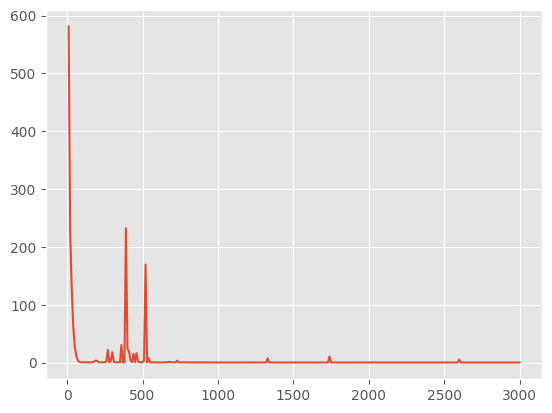

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('ggplot')
plt.plot(path_tr.loss_steps, path_tr.loss_values);

In [3]:
def plot_time_series_Error(path: PathResult):
    plt.figure()
    plt.hlines(0.1, 0, path.steps[-1], linestyles="dashed")
    # plt.plot(path.steps, path.FDPhat, label="Estimated FDP (strict mirror)")
    if path.FDR_true is not None:
        plt.plot(path.steps, path.FDR_true, label="FDR")
    if path.TypeII is not None:
        plt.plot(path.steps, path.TypeII, label="Type II error")
    else:
        plt.plot(path.steps, np.nan * np.ones_like(path.steps), label="Type II (n/a)")
    plt.xlabel("SGD steps")
    plt.ylabel("Rate")
    plt.title("Type I and II errors  over steps")
    plt.legend(facecolor="white")
    plt.show()


def plot_scatter_xi_M(
    xi1: Array, xi2: Array, M: Array,
    true_idx: Optional[Array] = None,
    selected_idx: Optional[Array] = None,
    tau: Optional[float] = None
):
    n = xi1.shape[0]
    # xi1
    plt.figure()
    plt.scatter(np.arange(n), xi1, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, xi1[true_idx], marker='o', label='Relevant features')
    plt.xlabel("Feature index")
    plt.ylabel(r"$\xi_{j1}$")
    plt.title(r"Split-1 importance $\xi_{j1}$")
    plt.legend(facecolor="white")
    plt.show()
    # xi2
    plt.figure()
    plt.scatter(np.arange(n), xi2, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, xi2[true_idx], marker='o', label='Relevant features')
    plt.xlabel("Feature index")
    plt.ylabel(r"$\xi_{j2}$")
    plt.title(r"Split-2 importance $\xi_{j2}$")
    plt.legend(facecolor="white")
    plt.show()
    # M
    plt.figure()
    plt.scatter(np.arange(n), M, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, M[true_idx], marker='o', label='Relevant features')
    if selected_idx is not None and len(selected_idx) > 0:
        plt.scatter(selected_idx, M[selected_idx], marker='s', facecolors='none', label='Selected')
    if tau is not None and np.isfinite(tau):
        plt.axhline(tau)
        plt.axhline(-tau)
    plt.xlabel("Feature index")
    plt.ylabel(r"$M_j$")
    plt.title(r"Aggregated importance $M_j$")
    plt.legend(facecolor="white")
    plt.show()

def plot_scatter_xi_M_at_best_TypeII(path: PathResult,
                                     true_idx: Optional[Array] = None):
    # チェックポイント数
    K = path.M_hist.shape[0]
    if K == 0:
        raise RuntimeError("No history recorded. Re-run with history enabled.")

    # t* を決める
    if (path.TypeII is not None) and np.isfinite(path.TypeII).any():
        # path.steps と hist の行は 1:1 対応（compute_every ごと）
        eps = 1e-12
        valid = np.isfinite(path.TypeII)
        vmin = np.nanmin(path.TypeII[valid])
        ties = np.where(valid & np.isclose(path.TypeII, vmin, rtol=0, atol=eps))[0]
        idx_star = int(ties[-1])  # ← 最後の出現（steps が単調増加なら最大の t）

        title_info = f"t*={path.steps[idx_star]} (min Type II={path.TypeII[idx_star]:.4g})"
    else:
        idx_star = K-1
        title_info = f"t*={path.steps[idx_star]} (Type II n/a)"

    xi1 = path.xi1_hist[idx_star]
    xi2 = path.xi2_hist[idx_star]
    M   = path.M_hist[idx_star]
    tau = path.tau[idx_star]
    selected = np.where(M > tau)[0] if np.isfinite(tau) else np.array([], dtype=int)

    # 既存の散布図関数のロジックを流用
    n = xi1.shape[0]
    # xi1
    plt.figure()
    plt.scatter(np.arange(n), xi1, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, xi1[true_idx], marker='o', label='Relevant features')
    plt.xlabel("Feature index"); plt.ylabel(r"$\xi_{j1}$")
    plt.title(rf"Split-1 importance $\xi_{{j1}}$ at {title_info}")
    plt.legend(facecolor="white"); plt.show()

    # xi2
    plt.figure()
    plt.scatter(np.arange(n), xi2, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, xi2[true_idx], marker='o', label='Relevant features')
    plt.xlabel("Feature index"); plt.ylabel(r"$\xi_{j2}$")
    plt.title(rf"Split-2 importance $\xi_{{j2}}$ at {title_info}")
    plt.legend(facecolor="white"); plt.show()

    # M
    plt.figure()
    plt.scatter(np.arange(n), M, marker='o', label='Null features')
    if true_idx is not None and len(true_idx) > 0:
        plt.scatter(true_idx, M[true_idx], marker='o', label='Relevant features')
    if selected.size > 0:
        plt.scatter(selected, M[selected], marker='s', facecolors='none', label='Selected')
    if np.isfinite(tau):
        plt.axhline(tau); plt.axhline(-tau)
    plt.xlabel("Feature index"); plt.ylabel(r"$M_j$")
    plt.title(rf"Aggregated importance $M_j$ at {title_info}")
    plt.legend(facecolor="white"); plt.show()

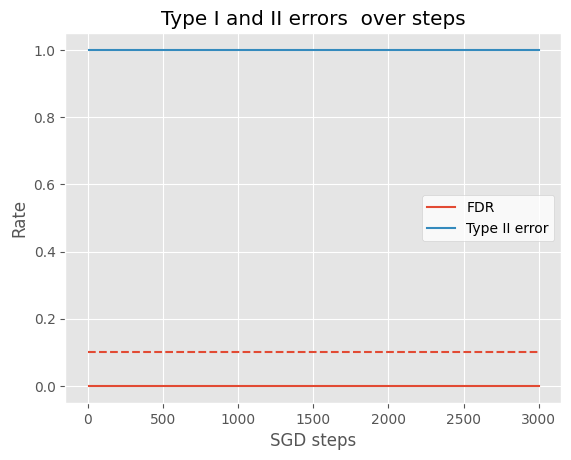

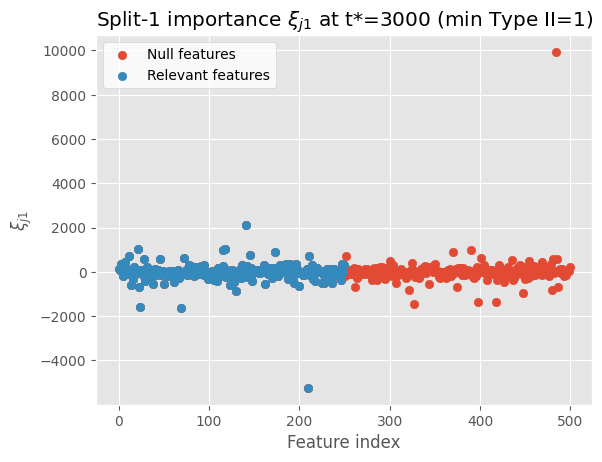

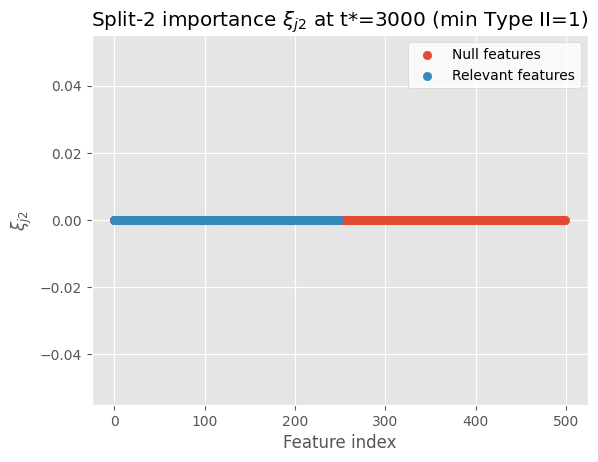

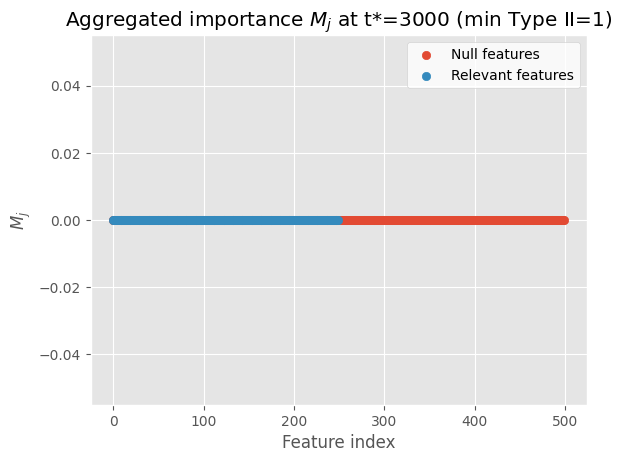

In [4]:
plot_time_series_Error(path_tr)
plot_scatter_xi_M_at_best_TypeII(path_tr, true_idx=true_idx)

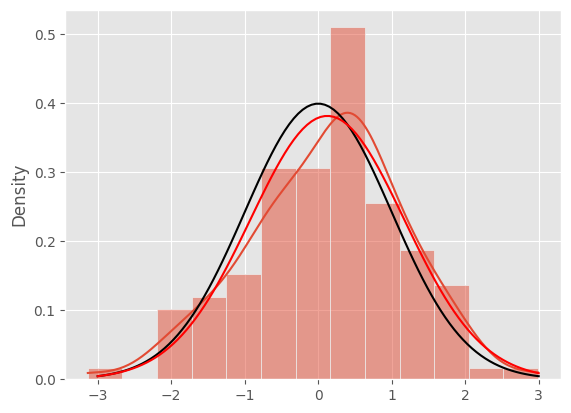

In [11]:
PBperp = np.eye(n) - B@np.linalg.inv(B.T@B)@B.T
const = np.sqrt((PBperp@path_tr.last_xi1)@(PBperp@path_tr.last_xi1))
norm = path_tr.last_xi1/const * np.sqrt(n)
sns.histplot(np.delete(norm,true_idx), kde=True, stat="density");
xxx = np.linspace(-3,3,100)
plt.plot(xxx, np.exp(-xxx**2/2)/np.sqrt(2*np.pi), color="black");
mean, std = np.mean(np.delete(norm,true_idx)), np.std(np.delete(norm,true_idx))
plt.plot(xxx, np.exp(-(xxx-mean)**2/(2*std**2))/(np.sqrt(2*np.pi)*std), color="red");